# Analysis of Experiment P1902

## Outline

1.  [Loading data](#Loading).  See the P1902 Preprocessing notebook, for the preparation of this data. 

2.  [Protein and mRNA distributions](#Protein) within and between clones for markers where we have information about both.

3. [Gene expressions as a signature of clonality](#Signature)  A machine learning approach to studying whether gene expression can predict clonotype.

4. [Differential gene expression](#DGE), including within and across traditional EFF/MEM categories.

<a id='Loading'></a>
# 1.  Loading and munging data

We begin by importing various packages and functions.  This notebook requires Python 3.5 or later, together with numpy, pandas, matplotlib, seaborn, statsmodels, scipy, scikit-learn (sklearn), bisect, and itertools.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.

from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE

# Put plots inline rather than in a pop-up.
%matplotlib inline

All data should be available from three pickles, produced by the Preprocessing notebook.

In [2]:
EM = pd.read_pickle('P1902_EM.pkl') # Load normalized expression matrix from a pickle.
protein_df = pd.read_pickle('P1902_protein.pkl') # Load proteins from a pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from a pickle.

We retrieve lists of genes, cells, and proteins from the loaded data.  The MEM/MIX/EFF clones are defined here (from knowledge of the experiment).

In [3]:
genes = list(EM.columns)  # The names of the genes. 
cells = list(EM.index) # The names of the cells.

proteins = list(protein_df.columns) # The names of the proteins
paired_proteins = [p for p in proteins if p in genes] # Proteins with paired genes.


clone_groups = {'MEM': ['H2', 'B4'], 'A7': ['A7'], 'EFF':['G6', 'A8', 'G8', 'H9', 'F3'], 'E4':['E4']}
clones = [clone for clonegroup in clone_groups.values() 
          for clone in clonegroup] #Pythonic flattening of list.
print(clones)

['H2', 'B4', 'A7', 'G6', 'A8', 'G8', 'H9', 'F3', 'E4']


We add MEM/MIX/EFF classification to the metadata.

In [4]:
def emm(clone):
    if clone in clone_groups['MEM']:
        return 'MEM'
    elif clone in clone_groups['EFF']:
        return 'EFF'
    else:
        return 'MIX'

meta_df['cell_type'] = meta_df['Clone_ID'].apply(emm)

`meta_df` is the dataframe holding the "metadata" of each cell (not the gene/protein expressions).  Let's just look at the first five cells, to see what the metadata looks like.

In [5]:
meta_df[:5]

,Project_ID,Donor,Number_Of_Cells,Clone_ID,In_Vivo_Clone_ID,cell_type
Sample_ID,,,,,,
P1902_1289,P1902,YFV2001,1,E4,52.0,MIX
P1902_1290,P1902,YFV2001,1,E4,52.0,MIX
P1902_1291,P1902,YFV2001,1,E4,52.0,MIX
P1902_1292,P1902,YFV2001,1,E4,52.0,MIX
P1902_1293,P1902,YFV2001,1,A7,46.0,MIX


Here we load a list of genes that are known to play a role in the memory (MEM) vs. effector (EFF) distinction. 

In [6]:
genes_me = pd.read_csv('MEM_EFF_List_Genes.csv').iloc[:,0].tolist()
genes_me = [gene for gene in genes_me if gene in genes]
print('{} MEM/EFF genes found in list of genes.'.format(len(genes_me)))

150 MEM/EFF genes found in list of genes.


Here we load a list of genes that are known to be innate immune genes, plus a few extras.

In [7]:
innate_df = pd.read_csv('InnateDB_genes.csv')
extragenes = pd.read_csv('marty-extra_genes.csv')
genes_innate = set(innate_df.name.unique()).union(set(extragenes.name.unique()))
genes_innate = sorted(genes_innate)
print('There are {} innate genes loaded, starting with {}'.format(len(genes_innate), genes_innate[:5]))

There are 828 innate genes loaded, starting with ['A2M', 'A2ML1', 'ABCB1', 'ABCF1', 'ACE']


For future convenience, we sort clones into MEM/MIX/EFF groups based on prior clonal identification.

In [8]:
cells_eff = meta_df[ meta_df['cell_type'] == 'EFF'].index
cells_mix = meta_df[ meta_df['cell_type'] == 'MIX'].index
cells_mem = meta_df[ meta_df['cell_type'] == 'MEM'].index

The following carries out a log-normalization on the protein expression data.

In [9]:
prolog = protein_df.copy()  # Make a copy in memory
prolog = prolog.apply(lambda column: column - column.min()) # Shift minima to zero.
prolog = prolog.transform(np.log1p) # Apply log(1+x) transform.

The following summarizes the data that has been loaded.  Double-check this, to make sure it matches expectation.

In [10]:
print("The expression matrix captures {} cells and {} gene expressions.".format(len(cells), len(genes)))
print("The protein matrix captures {} cells and {} proteins.".format(len(prolog), len(proteins)))
print("There are {} proteins paired with genes: {}.".format(len(paired_proteins), ', '.join(paired_proteins)))
print("Our cell metadata contains {} cells in {} clonotypes.".format(len(cells), len(clones)))
print("There are {} EFF-identified and {} MEM-identified cells.".format(len(cells_eff), len(cells_mem)))

The expression matrix captures 347 cells and 7409 gene expressions.
The protein matrix captures 361 cells and 24 proteins.
There are 5 proteins paired with genes: FAS, CD3E, CD8A, PDCD1, CD27.
Our cell metadata contains 347 cells in 9 clonotypes.
There are 178 EFF-identified and 90 MEM-identified cells.


<a id='Protein'></a>
# 2.  Protein / mRNA expression among clones.

We look at the relationship between protein and mRNA expression within and between clones.  At the single-cell level, within a clonotype, we can examine the location of a cell in "protein/gene space".  This leads to distributions for each clone, and these distributions vary between clones.

We begin the analysis by creating a dataframe with just the data of protein expression, matched gene expression, and a bit of metadata.

In [11]:
def make_pgframe(gf, pf, md, IV = True):
    serieslist = []
    cell_list = list(gf.index)
    for p in paired_proteins:
        p_df = pd.concat([gf.loc[pf.index & gf.index][p], 
                          pf.loc[pf.index & gf.index][p]], 
                         axis=1)
        p_df.columns = [p+'_gene', p+'_protein'] # Separate headers for gene and protein.
        serieslist.append(p_df)
    df = pd.concat(serieslist, axis=1)
    df['Clone_ID'] = meta_df.loc[gf.index].Clone_ID # Add clonality information.
    if IV:
        df['In_Vivo_Clone_ID'] = meta_df.loc[gf.index].In_Vivo_Clone_ID # Add in-vivo
    return df

We create the dataframe, and take a look at the first five cells.

In [12]:
pg_df = make_pgframe(EM, prolog, meta_df)
display(pg_df[:5])

,FAS_gene,FAS_protein,CD3E_gene,CD3E_protein,CD8A_gene,CD8A_protein,PDCD1_gene,PDCD1_protein,CD27_gene,CD27_protein,Clone_ID,In_Vivo_Clone_ID
P1902_1289,0.000000,7.237059,4.170297,6.576470,5.755718,10.276498,0.000000,6.848005,6.774163,6.253829,E4,52.0
P1902_1290,0.000000,9.118335,4.341648,7.882692,6.449046,9.105646,0.000000,6.363028,0.000000,7.280008,E4,52.0
P1902_1291,0.000000,8.366138,5.605912,7.889834,6.436838,10.095759,4.818236,7.160846,5.807950,6.822197,E4,52.0
P1902_1292,0.000000,8.603738,6.901590,6.282267,1.497642,0.000000,0.000000,6.232448,0.000000,7.261225,E4,52.0
P1902_1293,5.106469,8.127995,5.098362,8.052296,4.453832,9.688622,0.000000,3.988984,6.824791,7.848543,A7,46.0


We create a scatterplot, to show the distribution of cells in gene/protein space.  

In [13]:
def pg_scatter(pg, clone = None, cell_list = None, ax=None):
    # Subset the dataframe, either by given clonotype or by given cell-list.
    if clone:
        df = pg_df[ pg_df['Clone_ID'] == clone]
    elif cell_list:
        df = pg_df.loc[cell_list]
    
    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the density plot
    ax = sns.kdeplot(df[pg+'_gene'], df[pg+'_protein'],
                     cmap="Greys", shade=True, shade_lowest=False, alpha=0.7)
    
    genemean = df[pg+'_gene'].mean()
    protmean = df[pg+'_protein'].mean()
    if clone:
        ax.text(genemean, protmean, clone, size=16)
    f.suptitle('Distribution of {} gene/protein expression of {} cells'.format(pg, len(df)))

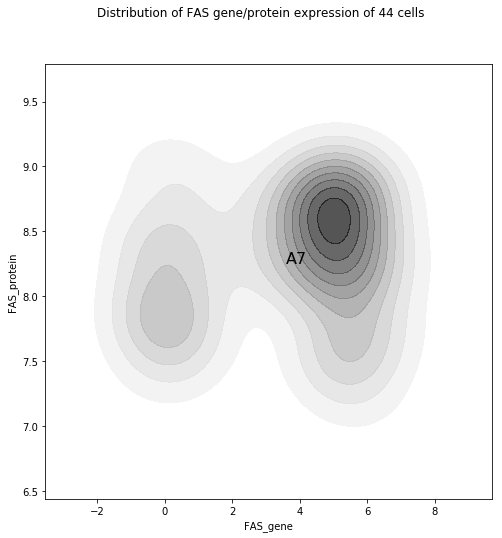

In [15]:
pg_scatter('FAS', clone='A7')

To compare two different clones, we overlay plots.

In [16]:
def pg_pair(pg,clonea, cloneb, ax=None):
    # Two subsets for the two clones.
    pg_df_a = pg_df[ pg_df['Clone_ID'] == clonea] 
    pg_df_b = pg_df[ pg_df['Clone_ID'] == cloneb]

    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    
    # Draw the two density plots
    ax = sns.kdeplot(pg_df_a[pg+'_gene'], pg_df_a[pg+'_protein'],
                     cmap="Reds", shade=True, shade_lowest=False, alpha=0.7)
    ax = sns.kdeplot(pg_df_b[pg+'_gene'], pg_df_b[pg+'_protein'],
                     cmap="Blues", shade=True, shade_lowest=False, alpha=0.7)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    
    genemean_a = pg_df_a[pg+'_gene'].mean()
    genemean_b = pg_df_b[pg+'_gene'].mean()
    protmean_a = pg_df_a[pg+'_protein'].mean()
    protmean_b = pg_df_b[pg+'_protein'].mean()
    
    ax.text(genemean_a, protmean_a, clonea, size=16)
    ax.text(genemean_b, protmean_b, cloneb, size=16)
    f.suptitle('Comparison of {} protein/gene expression between {} and {}'.format(pg, clonea, cloneb))
    return ax

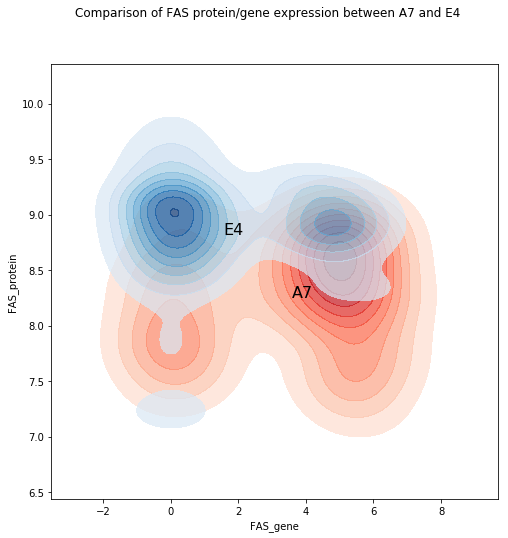

In [17]:
pg_pair('FAS','A7', 'E4')

Note that the "blobs" above zero arise from dropouts -- cells with no detected gene expression.  The above figure shows that E4 clones have significantly more FAS dropouts than A7 clones, but E4 clones (surprisingly?) have higher FAS protein expression.

Now we put together cells of the same clonotype, to compare statistics between clones.

In [18]:
def pg_compare(pg_list, ax=None, col_wrap = 5):
    serieslist = []
    for pg in pg_list:
        pg_df = pd.concat([EM[pg], prolog.loc[EM.index][pg]], axis=1)
        pg_df.columns = ['gene', 'protein'] # Separate headers for gene and protein.
        pg_df['Clone_ID'] = meta_df.loc[EM.index].Clone_ID # Add clonality information.
        pg_df_means = pg_df.groupby('Clone_ID').apply(lambda col : col.mean() )
        pg_df_means['protein and gene'] = pg
        serieslist.append(pg_df_means)
        
    df_means = pd.concat(serieslist, axis=0)
    
    sns.lmplot(x = 'gene', y = 'protein', data = df_means, col = 'protein and gene',
               sharex=False, sharey=False, truncate=True, height=3, ci=95, col_wrap = col_wrap)

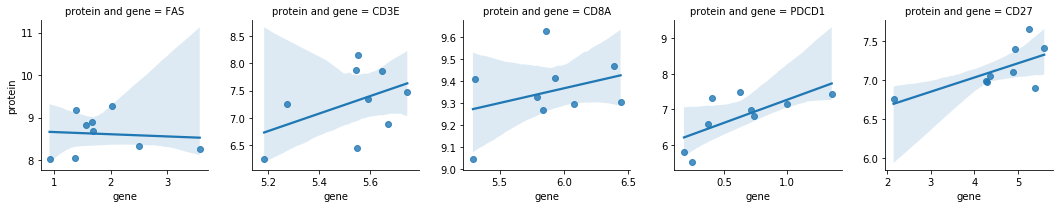

In [19]:
pg_compare(paired_proteins)

Here, each dot represents the mean gene expression and mean protein expression, for a given paired protein/gene and for all cells within a clonotype.  There seems to be a positive correlation between mean gene expression and mean protein expression -- but the 95% confidence intervals are too wide to tell in most cases.  (The P3128 data, with 24 clones, exhibits a stronger correlation between gene expression and protein expression.)

<a id='Signature'></a>
# 3.  Gene expression as a signature of clonality.

A central question is whether gene expression is a "signature" of clonality.  T-cells allow us to study this question because (1) the TCR genes certainly *do* provide a signature of clonality, so we *know* the clonotype of every cell, and (2) excluding the TCR genes, we can examine whether broad gene expression is a signature of this clonotype.  

We take a supervised machine learning approach to this question.  In this approach, a "signature" of clonality means that we can train the computer to predict clonality from gene expression.  We try three different machine learning approaches:

1.  A Bernoulli Naive Bayes (BNB) classifier, using binarized gene expression data.
2.  A Gaussian Naive Bayes (GNB) classifier, using genes which are very frequently expressed (above a cutoff).
3.  A Linear Support Vector (SVC) classifier, using genes selected by ANOVA F-statistic.

The approaches vary in their predictive accuracy, but all classifiers are far better than one would expect by chance.  They also go beyond what one might expect if the classifier was simply distinguishing cell types (e.g. memory vs. effector cells).  The Linear SVC classifier is most accurate, correctly predicting clonotype from gene expression about 95% of the time (using tuned parameters and a 80/20 training/testing split).

Each approach comes with a mode of feature selection and representation that carries additional information.  We study these along the way, to visualize the clonality signatures.

Using scikit-learn, the data is separated into an array `X` of gene expression (the "features") and an array `y` of clonalty (the "classes").  These will later be divided into training and validation sets.

In [20]:
X = EM.copy()  # The features.  Copied in memory, just in case.
y = meta_df.Clone_ID.loc[cells] # We are trying to predict clonality from the features.
y_ct = meta_df.cell_type[cells] # In case we just want to predict MEM/MIX/EFF type.

For comparison to random assignment to clonotypes, i.e. a null hypothesis, we also produce a shuffled list of clonality.

In [21]:
yshuff = pd.Series(np.random.permutation(y.values), index=y.index)

We provide some general-purpose functions for visualizing the results of cross-validation, and for examining the "confusion matrix" of a classifier.

In [22]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [23]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

Each machine learning approach will be paired with a set of "significant" genes.  To visualize the expression of these genes, we provide a few general-purpose functions here.

In [24]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [27]:
def vis_genebars(ef, mf, genelist, prop, classlist = None,z_score=True, binarize=False, 
                 cutoff = 1.0, num_genes = False, sort=True, genelabels = True, fitlabels = False):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        z_score:  Plot z-scores for each gene.
        binarize:  Plot binarized data, e.g. whether a gene is on or off.
        cutoff:  The cutoff for binarization.
        num_genes:  Plot an extra row, for the total number of genes expressed.
        sort:  If True, sort and hierarchically cluster the genes.
        genelabels:  Label the rows by genes if True.
        fitlabels:  If True, extend the height of the image to fit in all the gene labels.
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > 1.0).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    df[prop] = mf[prop]
    if classlist:
        df = sort_by(df, prop, classlist)
    else:
        df.sort_values(prop, inplace=True)
    
    cells = df.index
    md = mf.loc[cells]
    classes = md[prop].unique()

    # Create plot.
    if fitlabels:
        figheight = len(genelist) // 4
    else:
        figheight = 12
    fig, axes = plt.subplots(2,1, sharex = True, figsize=(12, figheight), 
                             gridspec_kw = {'height_ratios':[0.25, 11.75], 'hspace':0.005})
    
    
    pal = sns.cubehelix_palette(len(classes),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    lut = dict(zip(classes, pal))
    colors = pd.Series(df[prop]).map(lut)
    
    div_pal = sns.diverging_palette(220, 20, n=25)
    
    # Resort genes, based on hierarchical clustering and distance.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'
    if sort:
        Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
        genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]
    else:
        genelist_sort = genelist
        
    if num_genes:
        genelist_sort = ['num_genes'] + genelist_sort 
    
    if binarize:
        sns.heatmap(df[genelist_sort].transpose(), cmap='magma', ax=axes[1], cbar = None)
    elif zscore:
        sns.heatmap(df[genelist_sort].transpose(), vmin=-3, vmax=3, cmap = div_pal, ax=axes[1], 
                    cbar_kws={"orientation": "horizontal", "fraction":0.025, "pad":0.025})
    

    axes[0].vlines(cells,0,0.05, colors = colors, linewidth = 12*72 / len(cells))

    for c in classes:
        mdp = md[md[prop] == c]
        midcell = mdp.index[len(mdp) // 2]
        axes[0].text(midcell, 0.065, c, horizontalalignment='center')

    axes[0].axis('off')
    axes[0].grid(False)

    axes[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    if genelabels:
        axes[1].tick_params(axis='y', rotation=0)
    else:
        axes[1].yaxis.set_ticklabels([])

    title = []
    title.append('Expression for {} genes.'.format(len(genelist)))
    if binarize:
        title.append('Binarized gene expression.')
    elif z_score:
        title.append('Color represents z-score.')
    fig.suptitle('\n '.join(title))
    plt.show()

In [28]:
def correlelogram(ef, genelist, binarize=False, z_score = True, cutoff = 1.0, num_genes = False):
    
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    if num_genes and binarize:
        print('Warning:  Number of genes and binarized expression cannot both be plotted by this function.')
    if num_genes:
        df['num_genes'] = (ef[genelist] > cutoff).sum(axis=1)
    if binarize:
        df = df > cutoff
    elif z_score:
        df = df.apply(zscore)
    
    # Cluster and sort genes.
    if zscore:
        method,metric = 'average', 'euclidean'
    elif binarize:
        method,metric = 'complete', 'hamming'   
    Y = sch.linkage(df[genelist].transpose(), method=method, metric=metric)
    genelist_sort = [genelist[j] for j in sch.leaves_list(Y)]

    if num_genes:
        corr_matrix = df[['num_genes'] + genelist_sort].corr()
    else:
        corr_matrix = df[genelist_sort].corr()

    f, ax = plt.subplots(figsize=(18, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

    title = 'Correlations between expression of {} genes. \n'.format(len(genelist_sort))
    if binarize:
        title += 'Expression binarized with TPM cutoff {0:1.3f}.'.format(np.exp(cutoff)-1)
    elif z_score:
        title += 'Expression z-scores used for comparison.'
    f.suptitle(title)
    plt.show()

## 3.1  Machine learning via naive Bayes

scRNA gene expression data is complicated by dropouts (zeros) of biological and technical origin, some false-identifications (low expression counts which should be zero), and a generally complicated "real" distribution of gene expression in each cell.  A common model is ZINB (zero-inflated negative binomial), which is studied in [Risso et al.](https://www.nature.com/articles/s41467-017-02554-5), for example.

The ZINB model has three parameters (see Methods of loc. cit.), capturing dropout frequency and mean and dispersion (of the negative-binomial distribution).  Our Bayesian approach is a modification, which captures three closely related statistics:  the zero-frequency (zero = below a threshold hyperparameter) and the mean/std of the nonzero expressions.  This approach is computationally simpler (using existing tools) and separates phenomena which may have distinct biological origins.

Our Bayesian approach has two components: 

-  (Type B, for Binarized/Bernoulli) We binarize gene expression -- either a gene is expressed (above a threshold) or not.  We may use binarized gene expression to predict clonotype, choosing the most variable (binarized) genes by a $\chi^2$ statistic.  The hyperparameters are the threshold and the number of genes used for prediction.

- (Type G for Gaussian)  We consider only genes that are frequently expressed (e.g. >90% of cells express the gene).  We use differential expression of such genes to predict clonotype, choosing the most variably-expressed genes by an ANOVA F-statistic.  The hyperparameters are the number of frequently expressed genes in the first pool, and the number of differentially expressed genes used for prediction.

Along the way, we choose "significant" genes for prediction.  We study these genes, visualizing their expression profiles across clones.

### Type B:  The Bernoulli Naive Bayes Pipeline

We create a scikit-learn pipeline with three steps:  binarization, feature selection (selecting genes by a $\chi^2$-statistic), then using a Bernoulli Naive Bayes classifier.  Binarization turns all gene expressions into zeros or ones, depending on whether they reach a threshold. 

In [29]:
BNBpipe = make_pipeline(Binarizer(), SelectKBest(score_func = chi2), BernoulliNB())

To analyze the predictive power, we carry out 5-fold cross-validation on a grid of hyperparameters.  The first hyperparameter is the threshold for gene expression (for binarization).  The second is the number of genes (selected by $\chi^2$-statistic) used for prediction.

In [30]:
## DANGER DANGER.  Ignoring all warnings!
import warnings
warnings.filterwarnings("ignore")
##

param_grid = dict(binarizer__threshold=[0.01, 0.05, 0.075, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0],
                  selectkbest__k = range(10,251,20),
                 )
grid_search = GridSearchCV(BNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('binarizer', Binarizer(copy=True, threshold=0.0)), ('selectkbest', SelectKBest(k=10, score_func=<function chi2 at 0x1c1c70f488>)), ('bernoullinb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'binarizer__threshold': [0.01, 0.05, 0.075, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0], 'selectkbest__k': range(10, 251, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The following visualizes the results of cross-validation.

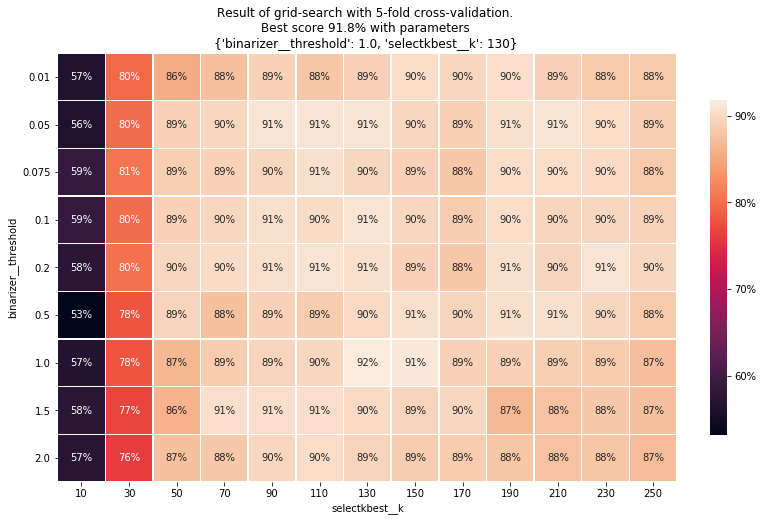

In [31]:
CV_map(grid_search)

We find that *binarized* gene expression data (whether a gene is expressed or not) yields a roughly 91% accurate predictor of clonotype, once hyperparameters are tuned (80-140 genes, with expression cutoff between 0.05 and 1.5).  The optimal hyperparameters are named below.

In [32]:
opt_threshold = grid_search.best_params_['binarizer__threshold']
opt_k = grid_search.best_params_['selectkbest__k']
print('Using tuned threshold {} and number of genes k={}'.format(opt_threshold, opt_k))

Using tuned threshold 1.0 and number of genes k=130


We run our Bernoulli Naive Bayes pipeline to study its predictions in more detail.  The data is divided into training and validation sets, in an 80%/20% ratio.  The classifier is trained on 80% and validated on 20%.  The "confusion matrix" displays the actual class (i.e., clonotype) and predicted class for each cell among the 20% in the validation set.

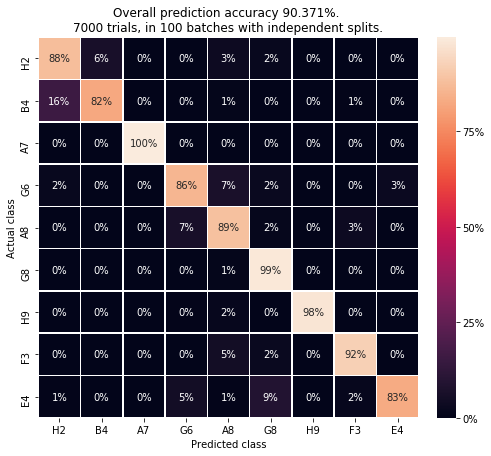

In [33]:
BNBpipe = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=opt_k), 
                        BernoulliNB())

confusion_matrix(X,y,BNBpipe, reps=100, classlist = clones)

This confusion matrix shows that the MEM clones (B4 and H2) are confused with each other somewhat frequently, but rarely with the MIX or EFF clones.  Similarly, the EFF clones (G6, A8, G8, H9, F3) are very rarely confused with the MEM clones.  Among the other two, the A7 clones are almost never confused with others, while the E4 clones are confused with EFF clones about 18% of the time.

Next, we visualize binarized gene expression as a "barcode" of clonality.  We select the top 150 genes, by $\chi^2$ statistic after binarization.  Gene expression is binarized, so bars display whether or not a gene is expressed.  Genes are hierarchically clustered, using hamming-distance and the "complete method" described in the [SciPy documentation](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.cluster.hierarchy.linkage.html).  Cells are organized into clones, and clones are organized from EFF (first 5 color-bars) to MEM (next 2 color-bars) to MIX (last 2 color-bars).

The top 150 genes, selected by chi2 statistic after binarization, are AFDN, AKR1C3, ANXA1, AOAH, ASB2, ATAD2, BIN1, C1orf21, C3orf14, C7orf50, CADM1, CAPG, CCDC50, CCL20, CCL23, CCR1, CCR2, CD200R1, CD28, CD300A, CD38, CD40LG, CD7, CD9, CDKN1A, CDKN2B, CEP85, CLECL1, CLIC3, CSF1, CTD-2116N17.1, CTSH, CTSL, CXCR3, CXCR6, DDAH2, DFNA5, DOCK5, DTL, EOMES, EPAS1, EXTL2, FAM49A, FCGR3A, FCMR, FEZ1, GGT1, GIMAP4, GLUL, GNG8, GPR15, GZMK, HIRIP3, HLA-DMA, HLA-DPA1, HLA-DQB1, HLA-DRA, HLA-DRB5, HOXB2, HPGD, ID3, IDH2, IFI44, IFI44L, IFITM1, IL10RA, IL18R1, IL18RAP, ISG20, JAML, KIAA0319L, KIAA1217, KLRB1, KLRC1, KLRC2, KLRC3, LAIR2, LAT2, LGALS3BP, LGALS9, LIME1, LPAR6, LRRC28, LRRN3, LST1, LTA, LYAR, MAP3K6, MCM5, MCUB, MKI67, MT1E, MT2A, MX1, NCF1, NCR1, NCR3, NELL2, NPTN, NUCB2, PATL2, PDE4DIP, PDE7B, PECAM1, PLEK, PLS3, PMCH, PRKCE, PTPRN2, PVRIG, RCBTB2, REG4, RGS1, RP11-277P12.6, RRP15, RUNX2, S1PR1, SALL4, SAMD3, SELL, SGK1, SHC4, SIRPG, SKIL, SLAMF7, SLC31A2, SLC4A10, SMCO4, SOCS1, SOX

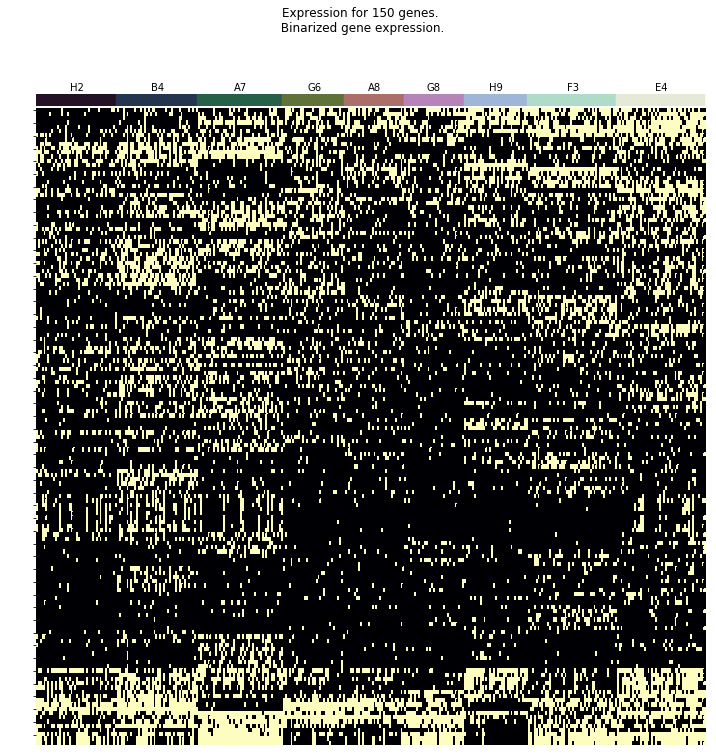

In [36]:
selector = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k=150))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

print('The top 150 genes, selected by chi2 statistic after binarization, are {}.'.format(', '.join(selected_genes)))

df = EM[selected_genes].copy()
vis_genebars(df, meta_df, selected_genes, 'Clone_ID', binarize=True, genelabels=False,
             sort=True, cutoff = opt_threshold, classlist=clones)

For later use, we create a dataframe of genes, together with their $\chi^2$ statistic and associated p-value after binarization.  Genes with low p-value are those whose dropout frequency exhibits statistically significant variability between clones.

In [44]:
selector = make_pipeline(Binarizer(threshold=opt_threshold), 
                        SelectKBest(score_func = chi2, k='all'))

selector.fit(X,y)
skb = selector.named_steps['selectkbest']
selected_genes = list(compress(genes, skb.get_support()))

onoff_genes = pd.DataFrame(index=selected_genes, columns=['chi2', 'p_value'])
onoff_genes.chi2 = list(compress(skb.scores_, skb.get_support()))
onoff_genes.p_value = list(compress(skb.pvalues_, skb.get_support()))
onoff_genes.sort_values('p_value', inplace = True)

The ten most significant on/off genes are below.

In [45]:
display(onoff_genes[:10])

,chi2,p_value
REG4,151.741560,8.493640e-29
GPR15,104.199343,5.901902e-19
TIMD4,103.984537,6.531314e-19
LRRC28,93.332320,9.776975e-17
CD40LG,86.807282,2.064491e-15
ID3,84.166172,7.063653e-15
CCL20,83.718750,8.697821e-15
GZMK,81.801610,2.119704e-14
JAML,81.016895,3.050919e-14
ANXA1,79.574175,5.955244e-14


In [51]:
print('There are {} genes, which exhibit statistically significant (p<0.01)  ' 
      'variability in dropout rate between clones.  In order of p-value, they are {}.'.format(
          len(onoff_genes[ onoff_genes.p_value < 1e-2]), 
          ', '.join(onoff_genes[ onoff_genes.p_value < 1e-2].index)
      ))

There are 537 genes, which exhibit statistically significant (p<0.01)  variability in dropout rate between clones.  In order of p-value, they are REG4, GPR15, TIMD4, LRRC28, CD40LG, ID3, CCL20, GZMK, JAML, ANXA1, KLRB1, S1PR1, CD300A, SLAMF7, SELL, CD200R1, STMN1, GNG8, RP11-277P12.6, PECAM1, ASB2, IFI44L, FAM49A, SAMD3, EPAS1, KLRC2, CCL23, STEAP1, LAIR2, CCDC50, CCR2, KLRC3, C1orf21, FCGR3A, CSF1, CD9, DOCK5, AOAH, LIME1, PLEK, SRRT, PATL2, PDE7B, CXCR6, RGS1, EOMES, LGALS3BP, RCBTB2, NCR1, SOX4, TRAT1, HLA-DRB5, CTSL, ZNF80, ISG20, IL18RAP, CAPG, CADM1, CDKN2B, USP18, SGK1, LTA, CTSH, SPOCK1, MT1E, MX1, HLA-DPA1, HLA-DQB1, ZBTB32, MKI67, CLECL1, HLA-DRA, PMCH, SHC4, RRP15, CD28, AKR1C3, MT2A, IFITM1, FCMR, SLC31A2, C3orf14, CLIC3, LPAR6, CCR1, CXCR3, GLUL, RUNX2, LGALS9, ZBTB20, MAP3K6, KLRC1, SLC4A10, ZWINT, CTD-2116N17.1, PLS3, KIAA1217, TC2N, IDH2, TNFSF8, LYAR, IL18R1, NPTN, HIRIP3, NUCB2, AFDN, BIN1, KIAA0319L, PDE4DIP, NCF1, CDKN1A, STAP1, HOXB2, CEP85, PVRIG, GGT1, SMCO4, IL1

### Type G:  The Gaussian Naive Bayes Pipeline.

Now we carry out a similar analysis using a Gaussian Naive Bayes classifier.  The general purpose visualizers are the same as before.

The pipeline has three steps:

1.  Selecting only genes which are frequently expressed (above a TPM=10 threshold).
2.  From this pool, select the genes whose expression levels vary most between classes.
3.  Train the Gaussian Naive Bayes classifier on these selected genes.

Step 1 requires a custom scoring for frequency of expression.  Step 2 uses an ANOVA F-statistic for scoring (which is built in).

In [52]:
def express_score(X,y, threshold = 10):
    '''
    Scoring a gene based on frequency of expression.
    Default threshold is log-transform of a raw count of 10.  log(10+1) = 2.4
    '''
    return np.array((X>np.log1p(threshold)).sum(axis=0))

In [53]:
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=600)), 
                    ('fval',SelectKBest(f_classif, k=100)), 
                    ('gnb',GaussianNB()) ]) 

We carry out 5-fold cross-validation on a grid of hyperparameters.  The two hyperparameters are the number of genes in the pool of *frequently* expressed genes, and the number of genes in the subpool of *differentially* expressed genes.  These are called `expr__k` and `fval__k`, respectively.

In [54]:
param_grid = dict(expr__k = range(200,1001,50), fval__k = range(10,161,10))
grid_search = GridSearchCV(GNBpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('expr', SelectKBest(k=600, score_func=<function express_score at 0x1c20950158>)), ('fval', SelectKBest(k=100, score_func=<function f_classif at 0x1c1c70f378>)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'expr__k': range(200, 1001, 50), 'fval__k': range(10, 161, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The results of cross-validation are displayed below, along with the optimal hyperparameters.

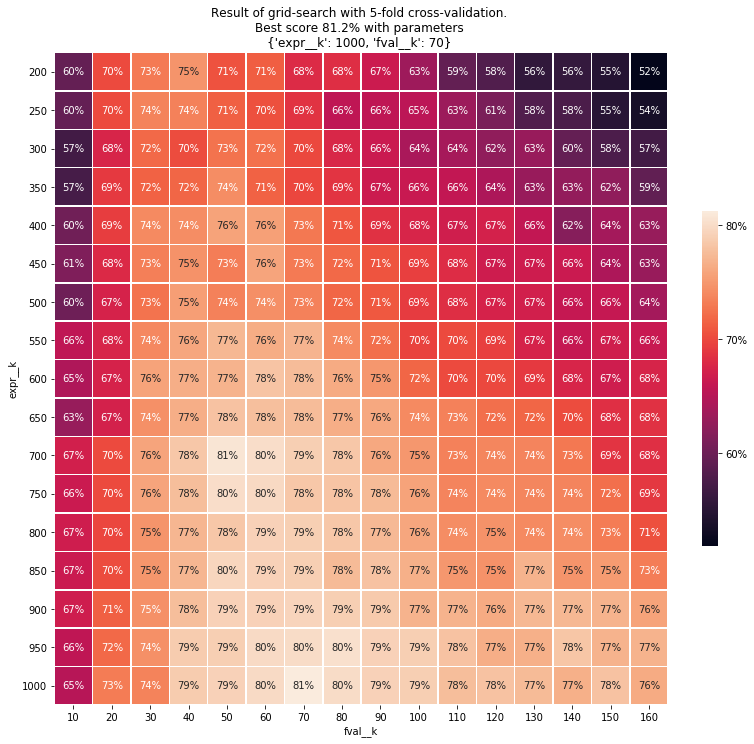

In [55]:
CV_map(grid_search)

The cross-validation indicates that it might be advantagous to keep more genes in the initial pool (selected by frequency of gene expression).  But in this circumstance, dropouts play a much larger role, and we wish to restrict our analysis to genes which are frequently expressed for now.  Thus we choose a non-optimal value (200) for `expr__k`, since we wish to limit our attention to the genes which are very frequently expressed.

We create a confusion matrix, to study the predictions in more detail. 

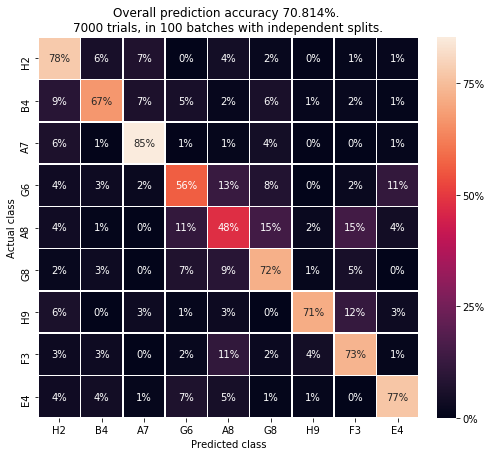

In [56]:
opt_expr__k = 200
opt_fval__k = 40
GNBpipe = Pipeline([ ('expr',SelectKBest(express_score, k=opt_expr__k)), 
                    ('fval',SelectKBest(f_classif, k=opt_fval__k)), 
                    ('gnb',GaussianNB()) ]) 

confusion_matrix(X,y,GNBpipe, reps=100, classlist = clones)

A similar pattern arises in this classification method, as with the binarized/Bernoulli approach.  There is more confusion within the MEM clones and within the EFF clones than there is *between* MEM and EFF clones.  The A7 clones are rarely frequently confused with others.

Now we select the 200 most frequently expressed genes for the starting pool, and then select the 50 most variably expressed genes (by ANOVA F-statistic) among the 200. We use the expression level of these 50 genes to produce a "gene expression barcode," to visualize this signature of clonality.

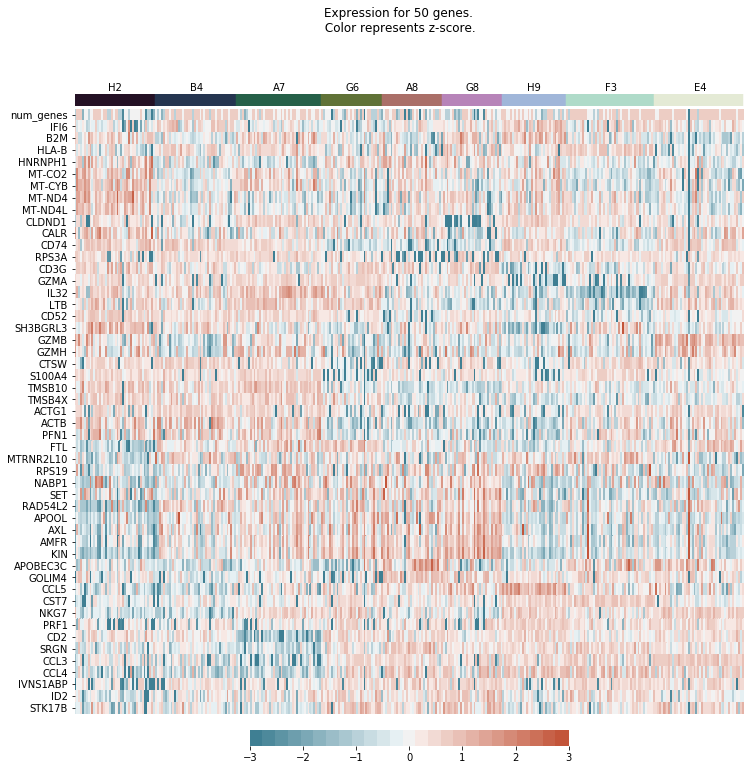

In [58]:
selector = Pipeline([ ('expr',SelectKBest(express_score, k=200)), 
                    ('fval',SelectKBest(f_classif, k=50))]) 

selector.fit_transform(X,y)
skbe = selector.named_steps['expr']
skbf = selector.named_steps['fval']

exp_genes = list(compress(genes, skbe.get_support())) # frequently expressed genes.
selected_genes = list(compress(exp_genes, skbf.get_support()))

df = EM[selected_genes].copy()
vis_genebars(df, meta_df, selected_genes, 'Clone_ID', sort=True, num_genes = True, classlist=clones)

Note that there seems to be a bad cell among the E4 clones (a long vertical stripe, including a low number of genes detected overall).  This should be examined, and possibly removed.

For later use, we create a dataframe of "tunable" genes.  These are genes which are very *frequently* expressed, but whose expression level varies significantly between clones.

In [67]:
selector = Pipeline([ ('expr',SelectKBest(express_score, k=200)), 
                    ('fval',SelectKBest(f_classif, k='all'))]) 

selector.fit_transform(X,y)
skbe = selector.named_steps['expr']
skbf = selector.named_steps['fval']

exp_genes = list(compress(genes, skbe.get_support())) # frequently expressed genes.
selected_genes = list(compress(exp_genes, skbf.get_support()))

tunable_genes = pd.DataFrame(index=exp_genes, columns=['nonzero_ratio', 'p_value'])
tunable_genes.nonzero_ratio = list(compress(skbe.scores_, skbe.get_support())) 
tunable_genes = tunable_genes.loc[selected_genes]
tunable_genes.p_value = list(compress(skbf.pvalues_, skbf.get_support()))
tunable_genes.nonzero_ratio = tunable_genes.nonzero_ratio / np.float64(len(X))
tunable_genes.sort_values('p_value', inplace = True)
# Print the ten most significant genes.
display(tunable_genes[:10])

,nonzero_ratio,p_value
IL32,1.000000,4.050501e-42
KIN,1.000000,3.908779e-40
CD2,0.991354,3.255883e-37
CD74,0.974063,3.133978e-25
CCL4,0.988473,7.111638e-25
CCL3,0.953890,3.718628e-22
FTL,0.997118,3.835717e-22
ACTB,1.000000,1.588426e-21
LTB,0.988473,1.479766e-20
CCL5,1.000000,1.686818e-20


In [68]:
print('We study {} frequently expressed genes.'.format(len(tunable_genes)))
print('Their maximum dropout rate is {0:2.1%}'.format(1 - tunable_genes.nonzero_ratio.min()))

We study 200 frequently expressed genes.
Their maximum dropout rate is 12.1%


In [70]:
print('Among these genes, {} vary significantly (p < 0.01) between clones.'.format(
    len(tunable_genes[ tunable_genes.p_value < 1e-2])))
print('These genes, ordered by p-value, are: {}'.format(', '.join(tunable_genes[ tunable_genes.p_value < 1e-2].index)))


Among these genes, 120 vary significantly (p < 0.01) between clones.
These genes, ordered by p-value, are: IL32, KIN, CD2, CD74, CCL4, CCL3, FTL, ACTB, LTB, CCL5, NKG7, B2M, SH3BGRL3, AMFR, TMSB10, SRGN, CLDND1, GZMA, APOBEC3C, GZMB, S100A4, CD52, MT-CO2, MT-CYB, APOOL, ID2, CD3G, RAD54L2, PFN1, GZMH, HLA-B, SET, AXL, MT-ND4, GOLIM4, CST7, CTSW, RPS19, TMSB4X, STK17B, MTRNR2L10, RPS3A, IFI6, IVNS1ABP, CALR, ACTG1, MT-ND4L, HNRNPH1, NABP1, PRF1, MT-ND5, H3F3B, RPL6, TXN, ARHGDIB, MT-CO1, ATP5E, LCK, MTRNR2L12, HLA-A, CFL1, MTRNR2L4, S100A11, PRDM1, CAP1, MT-ATP6, HLA-C, ARPC4, MTRNR2L8, ATP5J, CALM1, CD3D, RPS27, TPI1, PTPRCAP, PKM, EIF5A, GNLY, RPL15, MT-ATP8, MT-CO3, RPL21, SEPT7, LCP1, EEF1A1, DDX5, HOPX, PPP3CA, RPLP0, PABPC1, FTH1, CCND2, C16orf54, RPL5, ARF6, RPL34, CAPZA1, ATP5J2, PSME1, TPT1, MYL12B, OAZ1, RPL7, C6orf62, GMFG, RPL27A, RPL13A, HINT1, APOBEC3G, COX6C, GAPDH, YWHAE, RPL31, SERPINB9, UQCRQ, PIP4K2A, PFDN5, MT-ND1, CD8A, CKLF


 The clustering of genes exhibits some correlations in expression.  We create a correlation matrix below, and visualize gene-to-gene correlations in expression.  The number of genes is also included, so that we can see which higher-than-average gene expressions may be related to normalization issues.  For example, by carrying out TPM normalization at the beginning, those cells which express a large number of genes may have appear to have lower gene expressions (so that total expression per cell adds up to one million).
 
We focus here on the genes which exhibit significant variability at the $p < 10^{-6}$ level between clones.

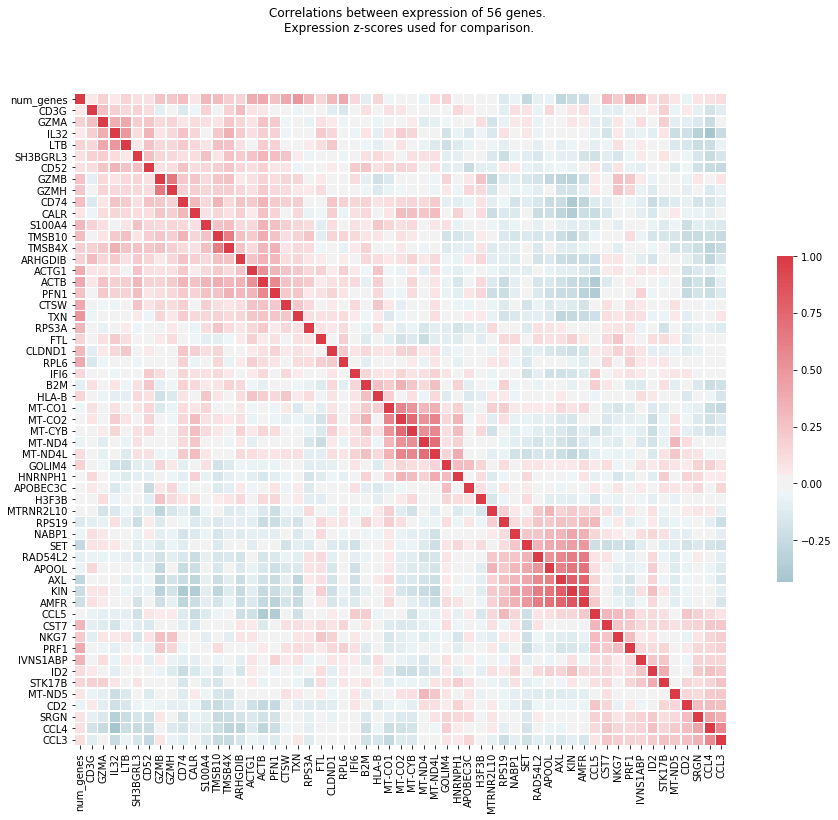

In [77]:
correlelogram(EM, tunable_genes[ tunable_genes.p_value < 1e-6].index, num_genes = True)

## 3.2:  Machine learning by linear SVM

Next, we take an entirely different approach to classification, using a soft-margin linear support vector classifier (SVC).  Support vector machines have been applied successfully in other genomic contexts -- see [Huang et al.](https://dx.doi.org/10.21873%2Fcgp.20063) for a survey in the context of cancer classification.  Our linear SVC pipeline has three steps.

1.  We pre-process the data by applying a linear function -- all gene-expressions will be shifted and scaled to lie between 0 and 1.  This is standard practice for linear SVM.

2.  We select the most variable genes by ANOVA F-statistic.  

3.  We apply the LinearSVC classifier and study the chosen genes.

4.  The LinearSVC classifier chooses weighted combinations of genes (we call these *metagenes*) that most effectively separate clones.  We study these weighted combinations in more detail and visualize them as signatures of clonality.

Regarding gene selection in step 2, we also attempted recursive feature elimination (RFE) with cross-validation.  This iteratively removes low-weighted genes from the metagenes, to select the genes most important for prediction.  While this might lead to improved classification with tuning, it did not make a big difference and it is computationally much more intensive.  On the other hand we do consider the weights of genes at the end, to better understand the selected metagenes.

We use 5-fold cross-validation and a grid search on the two most important hyperparameters.  These hyperparameters are the number of genes used in the classifier, and the C-parameter for the SVM.  In LinearSVC, the classifier tries to separate clonotypes by hyperplanes in gene-expression space.  Hyperplanes are scored by two criteria:

1.  Hyperplanes are considered better when the samples are farthest away from them (size of margin).

2.  Samples on the "wrong" side of the hyperplane count against the score, proportionally to how far on the wrong side they lie.  The C-parameter determines the penalty for these badly located samples, i.e., a higher C-parameter will be less tolerant of samples on the wrong side of the hyperplane.

In [78]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = range(25,301,25), svm__C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('mm', MinMaxScaler(copy=True, feature_range=(0, 1))), ('skb', SelectKBest(k=110, score_func=<function f_classif at 0x1c1c70f378>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'skb__k': range(25, 301, 25), 'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

We visualize the cross-validation results as before.

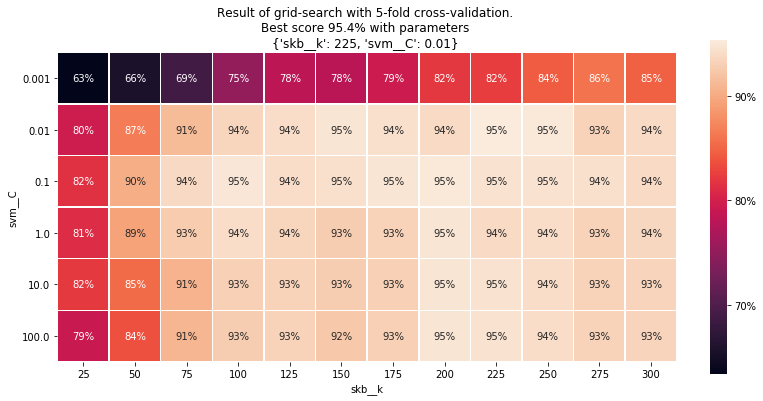

In [79]:
CV_map(grid_search, swap=True)

With minimal tuning, the SVM classifier (LinearSVC) exhibits better predictive accuracy than either of the Naive Bayes classifiers.  On the P1902 data, the SVM classifier achieves around 95% accuracy with 100-250 genes and a wide range of C-parameters.  The performance is excellent across a broad swath of parameters.  At least 50 genes seem necessary for achieving 90% accuracy in clonotype prediction.

This might be as good as it gets, though one could try other classifiers (e.g. neural net) just to see.  Next, we look at the confusion matrix, with tuned paramaters.

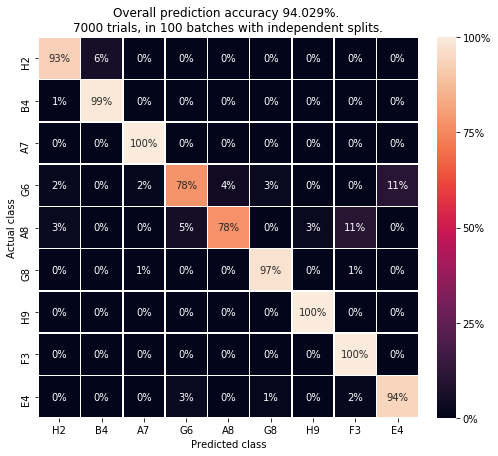

In [80]:
opt_skb__k = grid_search.best_params_['skb__k']
opt_svm__C = grid_search.best_params_['svm__C']

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=opt_skb__k)),
                     ('svm', LinearSVC(C = opt_svm__C)) ])

confusion_matrix(X,y,SVM_pipe, reps=100, classlist = clones)

Confusion is very rare, and exhibits the same pattern of MEM/EFF/MIX distinction as the other classifiers.  The E4 clones are never confused with MEM clones, but are occasionally confused with EFF clones. 

### Examination of "metagenes"

The first step in our SVM pipeline is the selection of significant genes, based on ANOVA F-statistic.  Note that we don't do any other filtering -- frequency of expression is not separately accounted for.  All we are looking at is the variation of gene-expression means among groups... and zeros will certainly affect these means!  Also, we are applying the F-statistic on non-normally distributed data.  We leave it to the statisticians to decide whether this is naughty.

We look at the 50 most significant genes, selected by this process.  Then, the support vector classifier attempts to separate the clones by considering weighted averages of these genes.  We describe these weighted averages, and visualize them as a signature of clonality.

In [81]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=50)),
                     ('svm', LinearSVC(C = 0.1)) ])

SVM_pipe.fit(X,y)
skbf = SVM_pipe.named_steps['skb']
lsvc = SVM_pipe.named_steps['svm']

diff_genes = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(len(diff_genes),', '.join(diff_genes)))

The 50 differentially expressed genes (selected by ANOVA F) are: ACTB, ALOX5AP, ANXA1, B2M, CCL3, CCL3L3, CCL4, CCL4L2, CCL5, CD2, CD200R1, CD40LG, CD74, CSF1, CXCR6, DOCK5, FGF23, FTL, GIMAP4, GPR15, HLA-DRB5, ID3, IFITM1, IFITM2, IFNG, IL2RA, IL32, JAML, KIN, KLRB1, KLRC1, KLRC2, KLRC3, KLRD1, LAG3, LAIR2, LGALS3BP, LRRC28, LTB, NKG7, PDGFA, PECAM1, PLEK, PLS3, REG4, RP11-277P12.6, SAMD3, SELL, SLAMF7, TIMD4


In [82]:
def make_metagene(coef_list, g_list):
    '''
    Represents SVC coefficients as a metagene, including both coefficients and genes.
    Metagenes are represented as Python dictionaries, with keys=genes, values=coefficients.
    '''
    return dict(zip(g_list, coef_list))

The linear support vector machine creates certain linear combinations of gene expressions, which are then used to classify clones.  We call these linear combinations *meta-genes* and study them below.

In [83]:
metagenes = [ make_metagene(coef_list, diff_genes) for coef_list in lsvc.coef_ ]

In [84]:
def display_weighted(metagene, cutoff = 0.1):
    '''
    Displays a list of coefficients as a weighted average of gene expressions.
    Displays only those genes which contribute above a cutoff to the weighted average.
    '''
    term_list = []
    cno = 0
    for gene in metagene.keys():
        coef = metagene[gene]
        if abs(coef) > cutoff:
            if coef >= 0:
                if cno > 0:
                    sgn_mark = ' + '
                else:
                    sgn_mark = ''
            else:
                sgn_mark = ' - '
            term = '{0:} {1:0.3f} {2:}'.format(sgn_mark, abs(coef), gene)
            term_list.append(term)
            cno += 1
    return ''.join(term_list) + '... (+ terms with coefficient < {})'.format(cutoff)      

In [85]:
mg_no = 0
for metagene in metagenes:
    mg_no += 1
    print('METAGENE {}: '.format(mg_no), display_weighted(metagene))
    print('---------------------------')

METAGENE 1:   0.297 ANXA1 -  0.231 CCL3 -  0.185 CCL3L3 -  0.108 CCL4 -  0.240 CCL4L2 -  0.144 CCL5 -  0.359 CD2 -  0.110 CD74 -  0.141 CSF1 -  0.399 CXCR6 +  0.106 GIMAP4 -  0.135 GPR15 +  0.257 ID3 -  0.133 IL2RA -  0.536 JAML -  0.109 KLRB1 -  0.111 KLRC1 +  0.301 KLRC2 +  0.312 KLRC3 +  0.314 KLRD1 -  0.260 LAG3 -  0.182 LAIR2 -  0.135 LRRC28 +  0.205 PECAM1 +  0.250 PLEK -  0.140 PLS3 -  0.106 REG4 +  0.261 RP11-277P12.6 +  0.367 SAMD3 +  0.387 SELL +  0.258 SLAMF7 -  0.215 TIMD4... (+ terms with coefficient < 0.1)
---------------------------
METAGENE 2:   -  0.193 ACTB +  0.455 ALOX5AP -  0.208 ANXA1 -  0.297 B2M +  0.294 CCL3L3 +  0.156 CCL4L2 -  0.157 CD200R1 -  0.415 CD74 +  0.487 CSF1 +  0.415 CXCR6 -  0.213 DOCK5 -  0.128 GIMAP4 -  0.272 GPR15 -  0.338 IFITM1 -  0.323 IFITM2 +  0.127 IL2RA +  0.127 IL32 +  0.316 KIN -  0.291 KLRC1 -  0.107 KLRC2 -  0.224 KLRD1 -  0.250 LAG3 -  0.268 LAIR2 -  0.131 LGALS3BP +  0.240 LRRC28 -  0.126 LTB -  0.148 NKG7 -  0.285 PDGFA +  0.289 PL

Now, we turn this around, and examine the genes which contribute to the metagenes.  Each metagene is a weighted combination of (up to 50) genes.  We select the genes whose contribution is above a cutoff to some metagene.

In [86]:
def under_genes(mg_list, cutoff = 0.1):
    '''
    Gets the most significant genes appearing in a list of metagenes.
    Significance is determined by weight, according to a cutoff.
    '''
    ug_set = set([])
    for mg in mg_list:
        for gene in mg.keys():
            if abs(mg[gene]) > cutoff:
                ug_set.add(gene)
    return ug_set

In [87]:
print('The following genes underlie the metagenes: {}.'.format(', '.join(under_genes(metagenes)) ) )

The following genes underlie the metagenes: KLRB1, KLRD1, JAML, CCL3, REG4, LTB, FGF23, LAG3, IFITM1, KLRC2, IL32, HLA-DRB5, FTL, CD74, TIMD4, RP11-277P12.6, CCL4L2, B2M, CD200R1, IFNG, CSF1, CXCR6, GIMAP4, IL2RA, KLRC3, ALOX5AP, CD40LG, PECAM1, LRRC28, CCL4, GPR15, LGALS3BP, KLRC1, LAIR2, CCL5, PLS3, ANXA1, CD2, PLEK, DOCK5, CCL3L3, SELL, SLAMF7, PDGFA, ID3, ACTB, IFITM2, KIN, SAMD3, NKG7.


Now we visualize the metagene-expression profile of our clones.  First, we create a dataframe with the metagene expression levels.

In [88]:
def add_metas(df, mg_list, mg_names='auto'):
    if type(mg_list) != list: # For adding single metagene.
        mg_list = [mg_list]
    mgname_list = []
    for j in range(len(mg_list)):
        if mg_names == 'auto':
            mg_name = 'Metagene {}'.format(j+1)
        else:
            mg_name = mg_names[j]
        mgname_list.append(mg_name)
        mg = mg_list[j]
        df[mg_name] = sum( (mg[gene]*df[gene] for gene in mg.keys() ))
    if mg_names == 'auto':
        return df, mgname_list
    else:
        return df

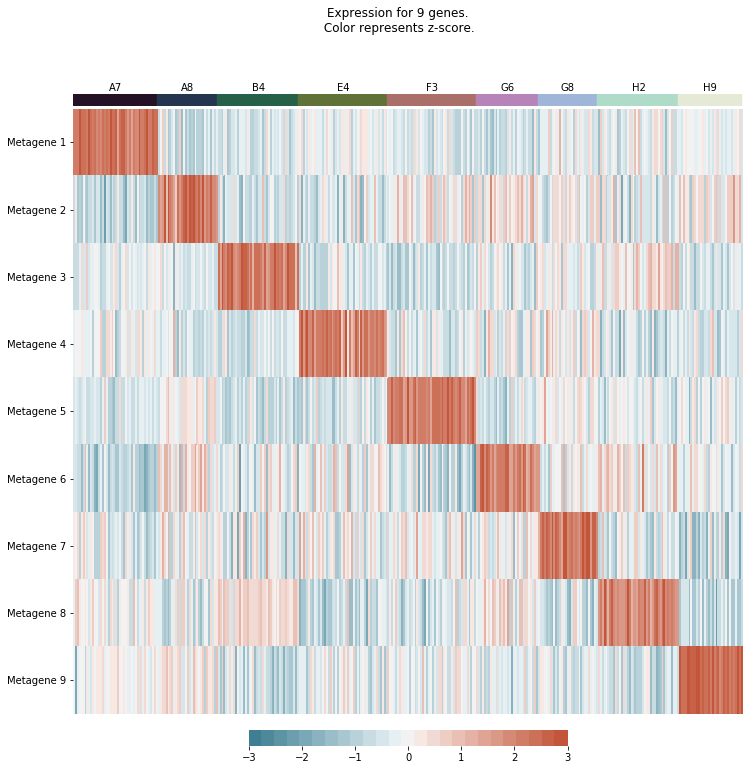

In [89]:
df = EM[diff_genes].copy()
df, metagene_list = add_metas(df, metagenes)
vis_genebars(df, meta_df, metagene_list, 'Clone_ID', sort=False)

In the figure above, we have used all of the cells in fitting the support vector classifier.  The resulting metagenes are overfitted as a result.  But separation into training/testing sets still leads to an excellent classifier.  The illustration above is meant to show *how* linear combinations of variably-expressed genes (our "metagenes") distinguish the clones.  And by fitting on all of the cells, the metagenes may carry better biological information.  The genes whose weights are the largest in the metagenes are those which are most significant for distinguishing clones.

Metagenes are also well-suited for scRNA data with a large proportion of dropouts.  By summming up contributions from many genes (with weights), the dropout-noise has a smaller effect without imputation.

For comparison, we make a similar plot, using the most significant (highly-weighted) genes occurring within the metagenes.

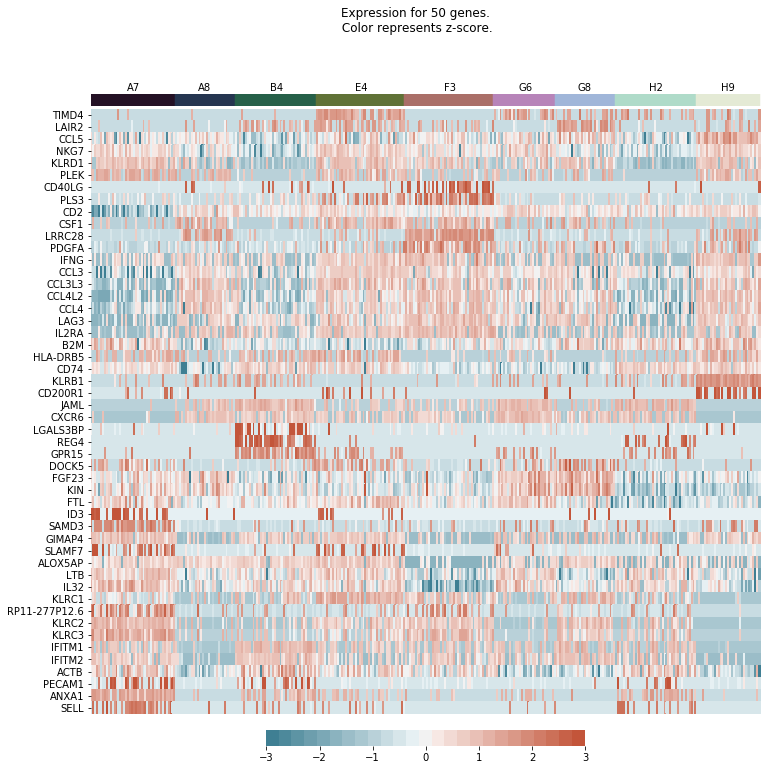

In [90]:
vis_genebars(EM, meta_df, list(under_genes(metagenes, cutoff=0.1)), 'Clone_ID')

Weighted combinations of these genes (the metagenes) do an excellent job of distinguishing clones, by "averaging out" the noise.  Still, one can see "blockiness" in the above picture, indicating the clonal specificity of the expression of these genes.  Some exhibit more binary behavior, and can be found in the earlier Bernoulli Naive Bayes approach.  Others are more "tunable" and can be found in the Gaussian Naive Bayes approach.

<a id='DGE'></a>
# 4.  Differential gene expression

Here we explore differential gene expression among clones, bewteen and within traditional EFF/MEM cell types.  We experiment with two basic approaches.  The first is parametric, based on the ANOVA F-statistic.  The second is nonparameteric, based on the Kruskal-Wallis H-statistic.  These statistics, F and H, are easy enough to compute, and have associated p-values.  The specific questions we have are the following:

1.  Is a gene XYZ expressed differently by different clones?
2.  If so, do the clonal differences in expression of XYZ primarily reflect the EFF/MEM status of the clone?
3.  Or, does the expression of XYZ distinguish one clone from all the others?

While the first question might be answered by F or H, the second and third require some deeper analyses.  If we answer the first question by the ANOVA F-statistic, it is natural to use Tukey HSD to answer the second and third.  If we answer the first question by the Kruskal-Wallis H-statistic, it is natural to use Dunn's test to answer the second and third.

We also try some more experimental approaches...

For more on differential expression analysis in scRNA data, see [Soneson and Robinson, Nature Methods volume 15, pages 255–261 (2018)](https://www.nature.com/articles/nmeth.4612).  They compare 36 approaches to identifying differentially expressed genes.  It would be interesting to apply our method to their data set to compare performance.  Since we haven't done a broad analysis, we take a conservative approach (i.e., using $p < 10^{-6}$ cutoffs in both parameteric and non-parameteric tests) to avoid Type I errors.  

Seurat, by default, uses the Wilcoxon ranked sum test for identifying differentially expressed genes, with the Bonferroni correction for multiple groups (I think).  Note that Kruskal-Wallis H is analogous to Wilcoxon, but designed for multiple groups (rather than corrected for them).  For practical purposes, our H-approach is the same as Seurat's default.

We import some more functions for this analysis.  This includes the new [scikit-posthocs package](https://github.com/maximtrp/scikit-posthocs).

In [91]:
import matplotlib.colors as pcolors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import mpl_toolkits.axes_grid1.colorbar as colorbar
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import scikit_posthocs as sp

### General purpose visualizations

In order to inspect a single gene's varying expression among the clones, the following function makes a swarm-plot, and gives the ANOVA F-statistic and Kruskal-Wallis H-statistic.

In [102]:
def swarm_gene(gene, clip = False):
    
    df = EM.copy()
    df['Clone_ID'] = meta_df.Clone_ID
    H = ss.kruskal(*[group[gene].values for name, group in df.groupby('Clone_ID')])
    F = ss.f_oneway(*[group[gene].values for name, group in df.groupby('Clone_ID')])
    df['num_genes'] = (EM[genes] > 2.4).sum(axis=1)
    
    df = df[[gene, 'Clone_ID', 'num_genes']]
    if clip:
        df = df[ df[gene] > 2.4 ] # Clip dropouts.
    df['z_genes'] = zscore(df['num_genes'])
    
    #create a figure
    fig,ax = plt.subplots(figsize=(9,6))
    
    # Apply a colormap.
    cmap = plt.get_cmap("viridis")
    norm = pcolors.Normalize(vmin=df['z_genes'].min(), vmax=df['z_genes'].max())    
    df['zc'] = df['z_genes'].apply(lambda cval : cmap(norm(cval)))
    
    # Create the swarmplot
    sns.swarmplot(x='Clone_ID', y=gene, data=df, hue = 'z_genes', 
                  palette=df['zc'], order=clones)
    
    ax.set_ylabel('Expression of {}, log-scale.'.format(gene))
    

    # Put the legend out of the figure
    plt.gca().legend_.remove()

    # create colorbar ##
    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.15)
    fig.add_axes(ax_cb)
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, orientation='vertical')
    cb1.ax.set_ylabel('z-score of number of genes expressed')

    title_lines = ['Differential expression of {0} among clones.'.format(gene)]
    title_lines.append('Kruskal-Wallis H-statistic {0:3.3f}, p-value {1:1.3e}.'.format(H.statistic, H.pvalue))
    title_lines.append('ANOVA F-statistic {0:3.3f}, p-value {1:1.3e}.'.format(F.statistic, F.pvalue))
    fig.suptitle('\n '.join(title_lines))
    plt.show()

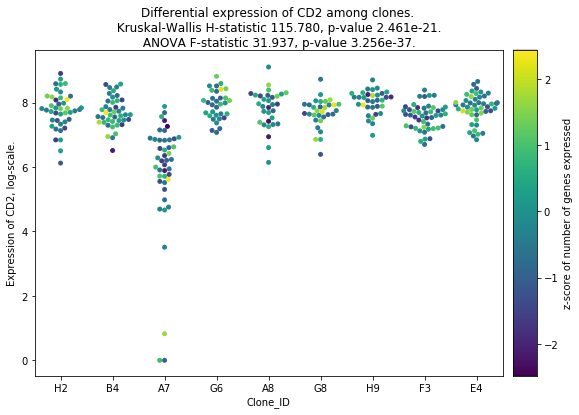

In [103]:
swarm_gene('CD2')

In this visualization of the differential expression of CD2, we see that A7 expresses the gene at lower levels than the other clones (with a few dropouts too).  Each dot stands for a cell, and the color indicates the total number of genes expressed by each cell.  We want to make sure that differential expression is not just due to total number of genes expressed (e.g., as an artifact of normalization).

### Non-parameteric approach, via Kruskal-Wallis

Our first function creates a data frame, the "KW-frame" whose rows are the clones and whose columns are the genes.  The entries are terms whose squares sum to the Kruskal-Wallis H-statistic.  Namely, if $h_{ij}$ is the entry for gene $i$ and clone $j$, then the Kruskal-Wallis H-statistic of gene $i$ is given by 
$$H = \sum_{j = 1}^g h_{ij}^2.$$
(Here $g$ is the number of clones.)  The entries of the KW-frame may be used later.

In [104]:
def KW_frame(gf, mf, prop = 'Clone_ID', genelist = None):
    if genelist:
        gf_rank = gf[genelist].rank()
    else:
        gf_rank = gf.rank()
    
    # Each column of gf_rank is a number between 1 and N.
    # N is the number of cells.
    N = len(gf_rank)
    meanrank = (1+N)/2 # Mean of all the ranks. 
    gf_rank[prop] = mf[prop] # Add the clonotype (or prop) to dataframe.
    pops = gf_rank[prop].value_counts() # Populations
    
    gf_rankmean = gf_rank.groupby(prop).apply(np.mean) # Compute mean ranks, the \bar r_i.
    
    ties = gf_rank.apply(lambda col : ss.tiecorrect(col))
    scaling = 12 / (ties * N*(N+1))
    H_frame = (gf_rankmean - meanrank).mul(np.sqrt(pops), axis=0)
    H_frame = H_frame * np.sqrt(scaling)
    return H_frame

In [105]:
EM_KW = KW_frame(EM, meta_df)
display(EM_KW)

,A1BG,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARSD1,...,ZSCAN26,ZSCAN30,ZSCAN32,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZZ3
A7,3.062291,0.137774,1.493813,0.329988,1.158682,0.665754,-0.739257,-0.478793,-1.116599,-1.650182,...,2.534186,0.783289,-1.746440,-0.772455,0.280948,0.709737,0.964685,2.325336,0.587394,-0.277226
A8,-1.643679,-0.404752,-0.198737,0.865104,-1.566619,-1.772518,-0.477682,0.875729,-0.367304,-1.041260,...,-0.641154,-1.411048,-0.040598,1.362511,-1.485870,-1.286717,-2.535114,-2.601179,0.117614,-0.845511
B4,1.850371,2.467780,-0.692188,1.766044,0.878310,1.584342,-0.241695,1.659079,1.765763,1.918257,...,-0.384030,2.091450,1.816604,1.172105,0.791459,-0.384754,3.049887,4.130773,1.998666,0.164575
E4,-1.087303,-0.500702,0.345402,0.948293,1.796092,1.243448,-0.916250,0.911782,-0.145520,0.140997,...,-0.478152,1.114691,-0.405489,1.169958,1.542063,0.001372,0.407159,1.728629,0.163172,-0.016268
F3,-2.250520,0.659947,-1.177307,-2.386910,1.625596,2.194407,1.889058,-1.634813,2.691463,1.780084,...,0.795684,0.558085,1.585850,-0.805449,0.507173,-0.438979,0.732202,-2.438230,-0.570620,0.889314
G6,0.337652,0.280884,-0.135691,-0.431708,-1.630058,0.128642,0.420431,-0.462503,0.135177,0.436207,...,-0.088881,0.488086,1.005627,0.539241,0.021552,0.958885,-0.465604,-2.642800,-0.138914,0.308823
G8,-1.276760,-1.676831,-0.051922,-1.960632,1.486050,-2.357986,1.477829,0.677214,-1.513931,-1.600994,...,-0.635134,-0.039672,-1.346503,-0.605163,-0.946264,0.419436,-1.130538,-2.601179,-2.008841,0.320370
H2,1.822180,-0.283635,1.095195,0.757992,-2.434964,-0.418389,-2.706000,-1.479894,-0.934331,-1.467677,...,-0.685307,-3.243296,-1.688716,-0.921379,-0.607368,-0.246932,-1.329346,3.058603,0.654770,-0.312125
H9,-1.240357,-1.070225,-0.820806,-0.043099,-1.938351,-2.266327,1.647143,0.154655,-0.964294,1.260402,...,-0.770213,-0.654535,0.832879,-1.086310,-0.615470,0.306110,-0.388812,-2.313289,-1.220875,-0.339320


We use this to compute the Kruskal-Wallis H-statistics and associated p-values for every gene.

In [106]:
H = (EM_KW**2).sum(axis=0)
pvals =  ss.distributions.chi2.sf(H, len(clones) - 1)
H_frame = pd.DataFrame.from_dict({'H' : H, 'pvalue':pvals})
H_frame = H_frame.sort_values('pvalue') # Sort by p-value.
H_frame.head()

,H,pvalue
REG4,227.226423,1.143041e-44
JAML,189.324954,1.129342e-36
ANXA1,168.582766,2.555420e-32
KIN,167.982398,3.413800e-32
CCL4L2,164.971107,1.458312e-31


The most significantly (by H-statistic p-value) differentially expressed gene is REG4.  To examine it more closely, we look at the swarm plot.  This also gives a check that the H-statistic and p-value are correct (since they were computed by different methods).

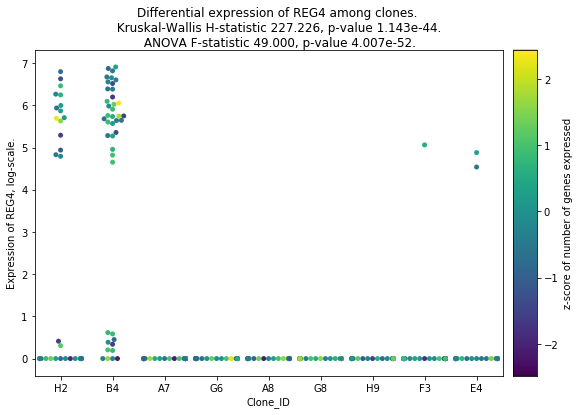

In [108]:
swarm_gene('REG4')

We say that a gene is H-DE, or *differentially expressed* according to H-statistic, if its p-value is below $10^{-6}$.  We choose this conservative cutoff, because even with $10^4$ genes, it would be unlikely to see such significant genes by chance.

To be more precise, there is a >99% chance of finding *zero* genes meeting the $p < 10^{-6}$ threshold in a random sample of genes of the size we're looking at (estimated below).  So if we *do* find such significant genes, we should pay attention to them.

In [109]:
print('{:1.3%}'.format( (1 - 1e-6)**len(H_frame) )) # Chance of finding no p<1e-6 genes, under null hypothesis.

99.262%


In [110]:
genes_H = H_frame[ H_frame.pvalue < 1e-6].index
print('There are {} H-DE genes'.format(len(genes_H)))

There are 338 H-DE genes


We visualize the expression of these H-DE genes, by z-score as before.  Note that there are too many genes to label, so labels in the figure may not align properly and many genes are unlabeled.

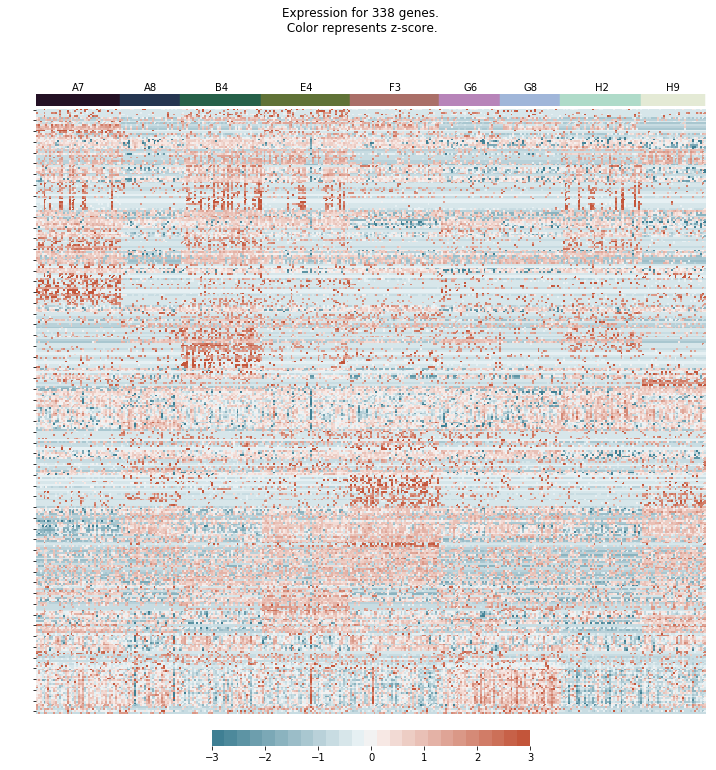

In [111]:
vis_genebars(EM, meta_df, genes_H, 'Clone_ID', genelabels = False)

In [113]:
print('The {} H-DE genes, in order of p-value, are: {}.'.format(len(genes_H), ', '.join(genes_H)))

The 338 H-DE genes, in order of p-value, are: REG4, JAML, ANXA1, KIN, CCL4L2, KLRC3, KLRC2, CXCR6, TIMD4, CD74, NKG7, IL32, LRRC28, GPR15, TMSB10, KLRD1, KLRC1, RP11-277P12.6, FGF23, KLRB1, SRGN, LAG3, PLEK, CCL3L3, IFITM1, ALOX5AP, LTB, FTL, CCL4, IFITM2, CCL3, B2M, IL2RA, CD52, CST7, LAIR2, CCL20, CD2, GZMK, TMSB4X, CCL23, MAF, IFNG, FAM49A, GZMA, RAB12, STMN1, CCL5, S100A4, ZBTB20, RRP15, ACTB, AMFR, ASB2, CD200R1, RDH10, HLA-DRB5, ADAM19, CSF1, ID3, EOMES, GIMAP4, FCGR3A, SH3BGRL3, CLDND1, S1PR1, GZMB, MGA, CD300A, SELL, SRRT, GNG8, PDGFA, APOOL, LTA, XBP1, HLA-DPA1, CD40LG, ISG20, STK17B, MT-CYB, APOBEC3C, MT-CO2, EPAS1, LRRN3, BTBD9, AOAH, MKI67, PLS3, CCR2, NUCB2, LGALS1, STEAP1, RCBTB2, CMTM6, HLA-B, NPTN, LPAR6, DOCK5, NCR3, NDFIP2, ID2, ITM2A, HLA-DQB1, HLA-DMA, MX1, LIME1, GOLIM4, CD9, CTSW, RASGEF1B, PFN1, GIMAP7, COTL1, IFITM3, LCK, LGALS3BP, ZNF302, CORO1A, RGS1, PRKCE, IFI6, HLA-DRA, LRRC69, CFL1, TRAT1, CADM1, TC2N, CD3G, CDKN1A, CXCR3, SPOCK1, PATL2, ARHGDIB, ZWINT, CR

In [114]:
genes_H_notinnate = [gene for gene in genes_H if gene not in genes_innate]
print('The {} non-innate H-DE genes are: {}'.format(len(genes_H_notinnate), ', '.join(genes_H_notinnate)))

The 255 non-innate H-DE genes are: REG4, JAML, ANXA1, KIN, TIMD4, NKG7, LRRC28, GPR15, TMSB10, RP11-277P12.6, FGF23, SRGN, PLEK, CCL3L3, ALOX5AP, FTL, IFITM2, CST7, TMSB4X, CCL23, MAF, FAM49A, RAB12, STMN1, CCL5, S100A4, ZBTB20, RRP15, ACTB, AMFR, ASB2, RDH10, ADAM19, ID3, EOMES, GIMAP4, SH3BGRL3, CLDND1, S1PR1, MGA, SRRT, GNG8, PDGFA, APOOL, XBP1, STK17B, MT-CYB, APOBEC3C, MT-CO2, EPAS1, LRRN3, BTBD9, AOAH, MKI67, PLS3, NUCB2, LGALS1, STEAP1, RCBTB2, LPAR6, DOCK5, NDFIP2, ID2, ITM2A, LIME1, GOLIM4, CTSW, RASGEF1B, PFN1, GIMAP7, COTL1, IFITM3, LGALS3BP, ZNF302, CORO1A, RGS1, PRKCE, IFI6, LRRC69, CFL1, TRAT1, CADM1, TC2N, CDKN1A, SPOCK1, PATL2, ARHGDIB, ZWINT, CRIM1, CTD-2116N17.1, EMP3, LY6E, ADD2, BCAS4, AXL, MT-ND4, ACTG1, CDKN2B, C1orf21, ANKRD1, HLA-DRB1, SKIL, SAMD3, SALL4, CTSH, SIT1, LSP1, HNRNPH1, MT-ND5, PTPRN2, MT-ND4L, PECAM1, C3orf14, IVNS1ABP, SET, SMCO4, MCM3, AKR1C3, ARID3A, MORC2, SLA, CTSL, RGS16, PHLDA1, HOXB2, SIRPG, MTRNR2L10, KIAA0319L, CAPG, VAMP5, KAT6A, RAD54L2,

For the genes that meet our strict $p < 10^{-6}$ threshold for H-significance, we can carry out a post-hoc analysis to identify the source of clonal differences.  This can also be seen from a swarm-plot, but a formulaic approach will be used later.  The Dunn test is a standard one for post-hoc analysis after Kruskal-Wallis, so that's what we use.  See [Dunn, Multiple Comparisons Using Rank Sums](https://www.jstor.org/stable/1266041) for more.

In [115]:
def dunn_chart(gf, mf, gene, prop='Clone_ID'):
    df = gf.copy()
    df[prop] = mf[prop]
    dunn_df = sp.posthoc_dunn(df, val_col = gene, group_col = prop, p_adjust='bonferroni')
    for clone in dunn_df.index:
        dunn_df.loc[clone, clone] = np.nan
    dunn_df = -np.log(dunn_df)
    fig,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(dunn_df, square=True, ax=ax, cbar_kws={'fraction':0.046, 'pad':0.04})
    fig.suptitle('Dunn rank-sum multiple comparisons for {}. \n'
                 'Color displays -log(p value).'.format(gene))

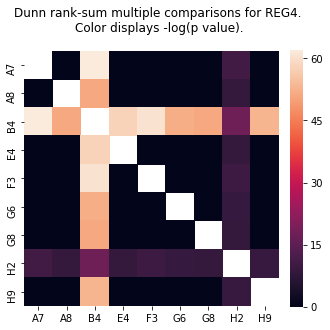

In [116]:
dunn_chart(EM, meta_df, 'REG4')

The `dunn_chart` function provides the (Bonferroni-adjusted) p-values for each pair of clones.  For example, in the REG4 case pictured above, we find a p-value in the neighborhood of $10^{-50}$ when comparing B4 clones and all others (except H2).  We find a p-value around $10^{-15}$ when comparing H2 clones to others.  One may interpret this as saying that REG4 distinguishes the clones B4 and H2 from the others.  This can also be seen on a swarm chart.

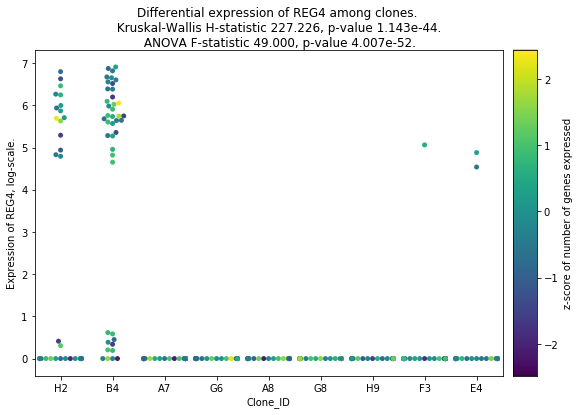

In [118]:
swarm_gene('REG4', clip=False)

We examine the Dunn chart for another, more often-expressed, gene below.

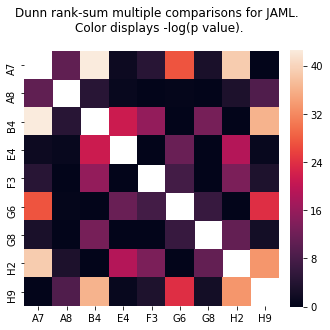

In [119]:
dunn_chart(EM, meta_df, 'JAML')

The black squares indicate that the gene does not behave differently for a pair of genes.  For example, JAML behaves differently between A7 and B4 (with $p < 10^{-35}$ or so).  But JAML does not behave so differently between A7 and H9.  This can be seen in the swarm chart below.

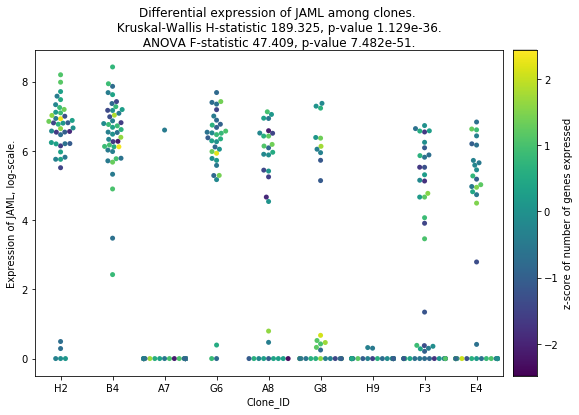

In [120]:
swarm_gene('JAML', clip=False)

Dunn's test can also be used to identify certain gene-expression "behaviors," in a somewhat coarse sense.  For example, the following function uses interquartile range to identify "outliers" after Dunn's multiple comparisons.  This may be used to find genes which behave differently for a *single* clone as compared to the rest.

In [121]:
def outliers(gf, mf, gene, coef, prop='Clone_ID'):
    df = gf.copy()
    df[prop] = mf[prop]
    dunn_df = sp.posthoc_dunn(df, val_col = gene, group_col = prop, p_adjust='bonferroni')
    for clone in dunn_df.index:
        dunn_df.loc[clone, clone] = np.nan
    dunn_df = -np.log(dunn_df)
    iso_df = dunn_df.sum(axis=0)
    out_indices = sp.outliers_iqr(iso_df, return_='outliers_indices', coef=coef)
    return list(iso_df.index[out_indices])

In [122]:
outliers(EM, meta_df, 'REG4', 1)

['B4']

The following function counts the number of outlier groups (clones), using interquartile range.  

In [123]:
def count_unique(gf, mf, gene, low_c = 1, high_c = 5, prop='Clone_ID'):
    way_out = outliers(gf,mf,gene,high_c,prop)
    little_out = outliers(gf,mf,gene,high_c,prop)
    if set(way_out) == set(little_out):
        return len(way_out)

Now we create a list of all genes which "isolate" one clone from the rest.

In [124]:
genes_Hsingle = [gene for gene in genes_H if count_unique(EM, meta_df, gene) == 1]
print('The {} isolating genes are {}.'.format(len(genes_Hsingle), ', '.join(genes_Hsingle)))

The 88 isolating genes are REG4, ANXA1, LRRC28, GPR15, KLRB1, ALOX5AP, CCL20, CD2, GZMK, AMFR, ASB2, CD200R1, ADAM19, ID3, S1PR1, GZMB, CD300A, SELL, SRRT, GNG8, LTA, CD40LG, AOAH, MKI67, PLS3, LGALS1, STEAP1, RCBTB2, CMTM6, NCR3, MX1, LGALS3BP, RGS1, PRKCE, TRAT1, CXCR3, PATL2, ZWINT, LY6E, MT-ND4, C1orf21, SAMD3, SIT1, PTPRN2, CTSL, SIRPG, IFI44L, CAPG, VAMP5, RAD54L2, AHNAK, CLIC3, MYO1E, AFDN, TK1, IL10RA, WSB2, SHC4, ZBTB32, PPP3CA, SERINC5, DFNA5, CD3D, DNAJC9, PELO, CCR1, DPYSL2, POU2F2, ITGA1, MCM2, PDE4DIP, CD27, IL18R1, HPGD, NCF1, ENTPD1, HIRIP3, WIPI1, LGALS9, ANXA2, SLC4A10, AP1S2, PMCH, MAP3K6, GGT1, IFI44, C6orf62, CISH.


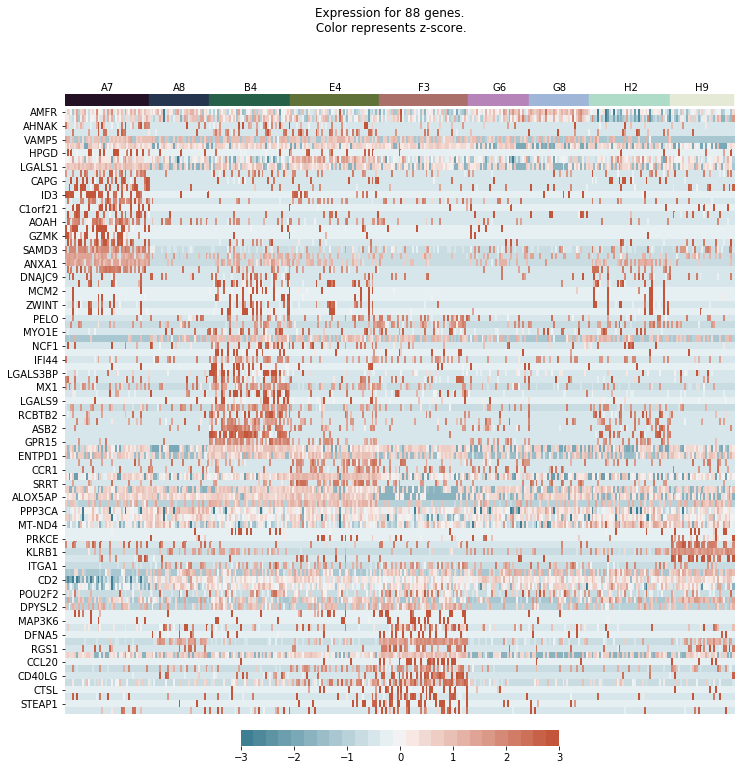

In [125]:
vis_genebars(EM, meta_df, genes_Hsingle, 'Clone_ID')

Some genes exhibit this "isolating" behavior by lacking expression in all but a single clone.  Others, like ALOX5AP seem to be expressed (somewhat unevenly) in all clones but one, where it is "shut off".  To see this in more detail, we look at the swarm-plot and Dunn's pairwise comparisons.

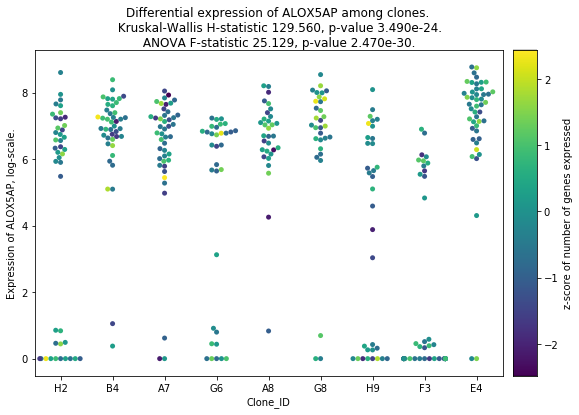

In [126]:
swarm_gene('ALOX5AP', clip=False)

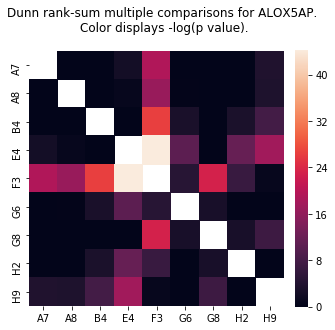

In [127]:
dunn_chart(EM, meta_df, 'ALOX5AP')

### Parametric approach via ANOVA F-statistic

Now we carry out a parametric analysis, in a similar manner.

In [128]:
def F_frame(gf, mf, prop = 'Clone_ID', genelist = None):
    if genelist:
        gfg = gf[genelist].copy()   
    else:
        gfg = gf.copy()
    
    N = len(gfg)  # N is the number of cells.
    all_mean = gfg.mean() # Mean of all the expression values. 
    gfg[prop] = mf[prop] # Add the clonotype (or prop) to dataframe.
    pops = gfg[prop].value_counts() # Populations
    K = len(pops) # K is the number of groups.
    scaling = (N-K) / (K-1)
    scaled = gfg.groupby(prop).apply(np.var).mul(pops, axis=0)
    scaling = scaling / scaled.sum()
    gf_means = gfg.groupby(prop).apply(np.mean) # Compute mean for each group, the \bar y_i.
    F_parts = (gf_means - all_mean).mul(np.sqrt(pops), axis=0)
    F_parts = F_parts * np.sqrt(scaling)
    return F_parts

In [129]:
EM_F = F_frame(EM, meta_df)
display(EM_F)

,A1BG,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARSD1,...,ZSCAN26,ZSCAN30,ZSCAN32,ZSWIM7,ZSWIM8,ZUFSP,ZWILCH,ZWINT,ZYX,ZZZ3
A7,1.106583,-0.022390,0.470549,0.137502,0.371288,0.653212,-0.121397,-0.092635,-0.536639,-0.419547,...,0.536733,0.131412,-0.535591,-0.160030,0.151953,0.304185,0.180123,0.681053,0.138397,0.096280
A8,-0.486508,-0.131499,-0.019066,0.526565,-0.430948,-0.670214,-0.111481,0.418142,-0.060423,-0.267575,...,-0.173013,-0.122346,0.148542,0.634805,-0.320549,-0.349188,-0.589321,-0.796254,0.258159,-0.300556
B4,0.713609,0.570293,-0.204164,0.253175,0.262819,0.271488,-0.004702,0.520624,0.213073,0.301378,...,-0.294579,0.526039,0.599661,0.139348,0.038296,-0.442488,1.260564,1.247394,0.754999,0.014163
E4,-0.394209,-0.235245,0.118654,0.171853,0.616436,0.425737,-0.252744,0.419472,0.094718,0.304324,...,0.138338,0.013297,-0.180579,-0.041130,0.589035,0.032854,0.114197,0.634417,-0.086855,0.012930
F3,-0.701667,0.255636,-0.493800,-0.486423,0.538476,0.043116,0.486734,-0.245685,1.225821,0.654083,...,0.226312,0.123540,0.546168,-0.110158,-0.041386,-0.165665,-0.134341,-0.802886,-0.011973,0.218675
G6,0.081351,0.270019,-0.199315,-0.195233,-0.732856,-0.217032,-0.078166,-0.424689,0.032650,0.105887,...,0.024772,0.495813,0.349444,0.074305,0.101239,0.391904,-0.081053,-0.808995,-0.228884,0.068772
G8,-0.526172,-0.533560,-0.071519,-0.599270,0.524460,-0.785014,0.378023,0.152316,-0.580764,-0.429604,...,-0.159652,0.101562,-0.591240,-0.033040,-0.124228,0.130195,-0.351098,-0.796254,-0.647141,0.114189
H2,0.394704,0.024147,0.486660,0.155610,-0.687283,0.240776,-0.796941,-0.363715,-0.337624,-0.322035,...,-0.093246,-1.027628,-0.520677,-0.060082,-0.256658,-0.081895,-0.241469,1.028187,0.293557,-0.120304
H9,-0.332865,-0.290145,-0.135055,0.014172,-0.682383,-0.261569,0.586926,-0.409931,-0.209627,-0.052337,...,-0.314733,-0.215527,0.182672,-0.382433,-0.244304,0.223479,-0.342607,-0.814571,-0.623655,-0.151968


In [130]:
F = (EM_F**2).sum(axis=0)
pvals =  ss.f.sf(F, len(clones) - 1, len(EM) - len(clones))
F_frame = pd.DataFrame.from_dict({'F' : F, 'pvalue':pvals})
F_frame = F_frame.sort_values('pvalue') # Sort by p-value.
F_frame.head()

,F,pvalue
LRRC28,57.764303,9.235270e-59
REG4,48.999838,4.007039e-52
JAML,47.408743,7.482115e-51
KLRC2,41.756423,3.747438e-46
KLRC3,38.422557,3.096761e-43


The most significant gene, by F-statistic, is LRRC28.  It's swarm plot is below.

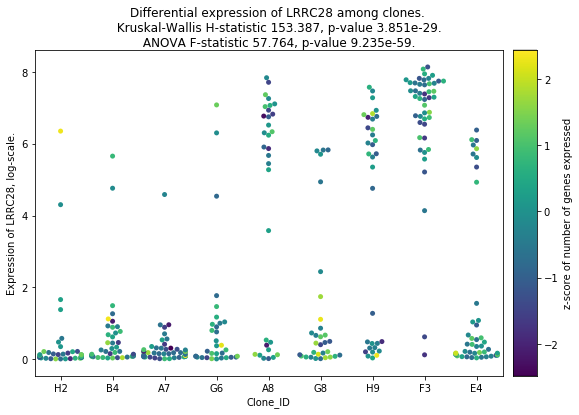

In [131]:
swarm_gene('LRRC28')

We select the genes which are differentially expressed according to the F-statistic below.  As for the H-statistic, we use the conservative $p < 10^{-6}$ cutoff.

In [132]:
genes_F = F_frame[ F_frame.pvalue < 1e-6].index
print('There are {} F-DE genes:  {}'.format(len(genes_F), ', '.join(genes_F)))

There are 299 F-DE genes:  LRRC28, REG4, JAML, KLRC2, KLRC3, CCL4L2, IL32, KIN, CXCR6, KLRD1, ANXA1, CD2, TIMD4, PLS3, GPR15, KLRB1, CCL3L3, KLRC1, ALOX5AP, LAG3, LAIR2, IFITM2, PLEK, SAMD3, IFITM1, CD74, CCL4, CD40LG, PDGFA, LGALS3BP, RP11-277P12.6, CSF1, CCL3, FTL, SLAMF7, HLA-DRB5, GIMAP4, ACTB, IL2RA, FGF23, LTB, CCL5, CD200R1, ID3, NKG7, PECAM1, B2M, DOCK5, SELL, IFNG, RAB12, CCL20, FAM49A, S1PR1, GNG8, ASB2, SH3BGRL3, MAF, AMFR, STMN1, TMSB10, NPTN, SRGN, ZNF80, EOMES, CCL23, RDH10, SRRT, CD300A, CADM1, CLDND1, GZMA, FCGR3A, IFI44L, APOBEC3C, EPAS1, MGA, PDE7B, CCR2, LRRN3, GZMB, AOAH, GZMK, XBP1, S100A4, NDFIP2, HLA-DQB1, CD9, CD52, GIMAP7, STEAP1, RCBTB2, LPAR6, LIME1, PATL2, HLA-DMA, LTA, HLA-DPA1, COTL1, NCR3, C1orf21, NUCB2, CMTM6, ISG20, SKIL, RGS1, SOCS2, MX1, MT-CO2, CRIM1, SGK1, MT-CYB, CCDC50, CXCR3, APOOL, TRAT1, LAT2, VAMP5, ITM2A, PCLAF, HLA-DRA, CTSL, ID2, ANKRD1, IFITM3, CD3G, RAD54L2, CD82, SIRPG, PFN1, GZMH, SIT1, CD28, HLA-B, PHLDA1, PDE4DIP, MT2A, SLA, CORO1A, 

We visualize the expressions of these differentially expressed genes below.

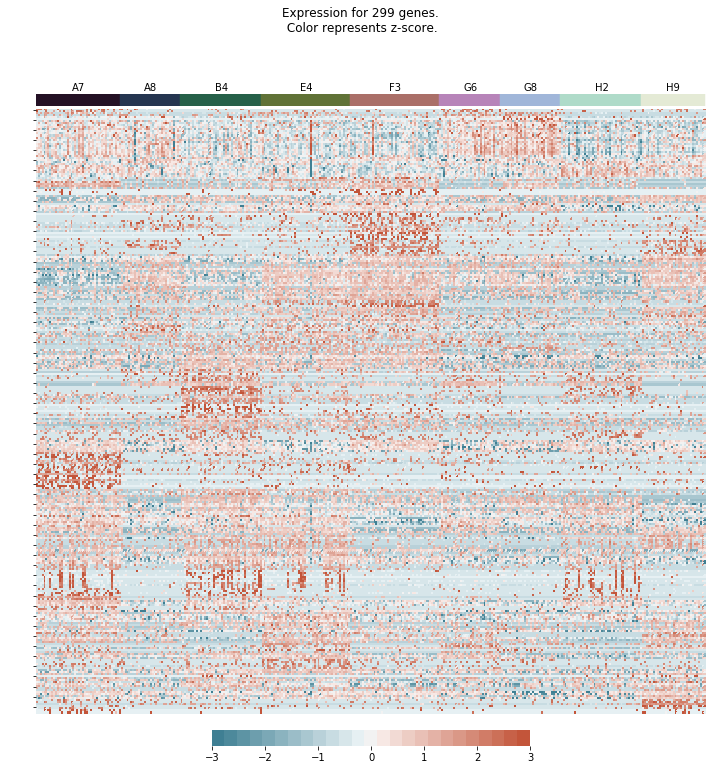

In [135]:
vis_genebars(EM, meta_df, genes_F, 'Clone_ID', genelabels = False)

### Comparison of parametric and nonparametric results

We compare the genes selected by F-statistic and those selected by H-statistic.

In [136]:
genes_FH = list(set(genes_F).intersection(genes_H))
print('The {} F-DE genes and {} H-DE genes intersect '
      'in {} FH-DE genes: {}.'.format(len(genes_F),len(genes_H),
                                      len(genes_FH),', '.join(genes_FH)))

The 299 F-DE genes and 338 H-DE genes intersect in 257 FH-DE genes: MT-ND4, SIRPG, CCL3, MT-ND5, HLA-DRA, CCR1, ANXA2, CXCR3, LAG3, ISG20, CLECL1, CLIC3, SLC31A2, ANKRD1, CD28, CD200R1, CCL4L2, SIT1, MTRNR2L10, FAM49A, COTL1, CD40LG, RDH10, HLA-DPB1, CDKN1A, CRIM1, SALL4, SOCS2, CAPG, GPR15, SH3BGRL3, STK17B, WIPI1, PVRIG, LY6E, S100A4, GZMK, FKBP11, HLA-DRB1, RASGEF1B, ITGB1, ACTG1, CREM, FCMR, SELL, PLSCR1, ACTB, SET, IFITM2, PCLAF, GZMB, SAMD3, GZMH, NKG7, CORO1A, TRAT1, KIAA0319L, PALLD, HLA-DMA, NDFIP2, TC2N, JAML, BIN1, NAMPT, ZNF302, REG4, ENTPD1, AXL, CTSW, KLRC2, MX1, CADM1, HLA-G, SERINC5, IL32, HLA-DRB5, ARHGDIB, CTSC, CMTM6, ASB2, MAF, RGS1, RAD54L2, NABP1, CTLA4, FUT8, RAB29, ADAM19, RUNX2, IL2RA, KLRK1, NUCB2, PECAM1, EMP3, HLA-DPA1, LMAN1, GIMAP7, SPOCK1, LGALS3BP, STEAP1, CTSL, PCSK5, KLRC1, MT-ND4L, IFI44L, ADD2, PLEK, ID2, CCL3L3, PDGFA, GZMA, IFI6, PRF1, AOAH, ISG15, SRRT, KIN, CDKN2B, CCR2, ZBTB20, HLA-B, KLRC4, XAF1, SIRPB1, LPAR4, C1orf21, MAP3K6, CST7, NFATC3, XB

In [138]:
genes_FH_noninnate = [gene for gene in genes_FH if gene not in genes_innate]
print('Among the {} FH-DE genes, {} are *not* innate.'.format(len(genes_FH), len(genes_FH_noninnate)) )
print('These non-innate differentially expressed genes are {}.'.format(', '.join(genes_FH_noninnate)))

Among the 257 FH-DE genes, 185 are *not* innate.
These non-innate differentially expressed genes are MT-ND4, SIRPG, MT-ND5, ANXA2, CLECL1, CLIC3, SLC31A2, ANKRD1, SIT1, MTRNR2L10, FAM49A, COTL1, RDH10, CDKN1A, CRIM1, SALL4, CAPG, GPR15, SH3BGRL3, STK17B, WIPI1, PVRIG, LY6E, S100A4, FKBP11, HLA-DRB1, RASGEF1B, ACTG1, CREM, FCMR, PLSCR1, ACTB, SET, IFITM2, PCLAF, SAMD3, NKG7, CORO1A, TRAT1, KIAA0319L, PALLD, NDFIP2, TC2N, JAML, BIN1, NAMPT, ZNF302, REG4, AXL, CTSW, CADM1, HLA-G, SERINC5, ARHGDIB, CTSC, ASB2, MAF, RGS1, RAD54L2, NABP1, FUT8, RAB29, ADAM19, RUNX2, NUCB2, PECAM1, EMP3, LMAN1, GIMAP7, SPOCK1, LGALS3BP, STEAP1, CTSL, PCSK5, MT-ND4L, ADD2, PLEK, ID2, CCL3L3, PDGFA, IFI6, AOAH, ISG15, SRRT, KIN, CDKN2B, ZBTB20, XAF1, SIRPB1, LPAR4, C1orf21, MAP3K6, CST7, XBP1, ZWINT, FGF23, HNRNPA1, RNF19A, SUPT3H, TMSB10, LYAR, RHOH, GOLIM4, TIMD4, APBB2, GNPTAB, EPAS1, S1PR1, GIMAP4, NBPF14, CCL23, USP18, SMCO4, FXYD5, PATL2, EOMES, LRRN3, MT-CYB, PPP2R5C, ITM2A, LGALS1, PFN1, LIME1, IFI44, M

In [209]:
FH_frame = pd.concat([F_frame, H_frame], axis=1)
FH_frame.columns = ['F', 'F_logpvalue', 'H', 'H_logpvalue']
FH_frame.F_logpvalue = -np.log(FH_frame.F_logpvalue) / np.log(10)
FH_frame.H_logpvalue = -np.log(FH_frame.H_logpvalue) / np.log(10)
FH_frame = FH_frame[ (FH_frame.F_logpvalue > 3) | (FH_frame.H_logpvalue > 3) ]
FH_frame.head()

,F,F_logpvalue,H,H_logpvalue
A1BG,3.168256,2.750171,28.353201,3.385582
ABI3,5.397132,5.679083,38.017966,5.126623
ACAA2,4.280352,4.193143,23.598719,2.572696
ACAD11,3.367398,3.003943,27.395669,3.219026
ACAT1,2.788343,2.274367,30.767996,3.811055


Here we examine the genes that are significant ($p < 10^{-6}$) with respect to one statistic but not significant ($p > 10^{-3}$) with respect to another.

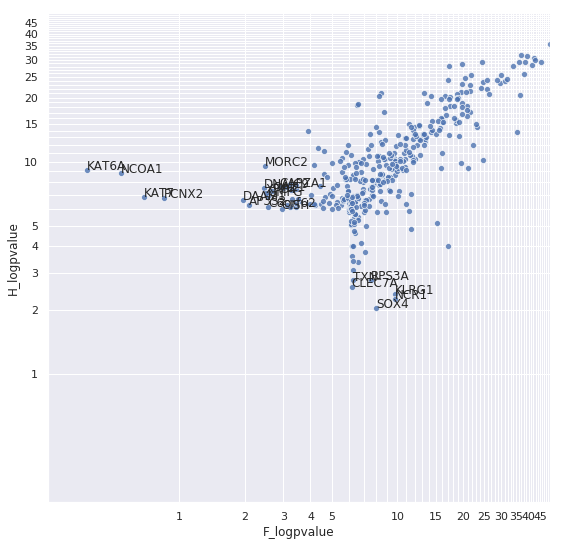

In [211]:
fix,ax = plt.subplots(figsize=(9,9))
FH_frame6 = FH_frame[ (FH_frame.F_logpvalue > 6) | (FH_frame.H_logpvalue > 6) ]
sns.scatterplot(x='F_logpvalue', y='H_logpvalue', 
                data=FH_frame6, alpha=0.8, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xbound(0.25,50)
ax.set_ybound(0.25,50)

ax.set_xticks(range(1,50))
ax.set_yticks(range(1,50))
ll = list(range(1,50))
for j in range(len(ll)):
    if (ll[j]%5 != 0) and (ll[j] > 5):
        ll[j] = ''
ax.set_xticklabels(ll)
ax.set_yticklabels(ll)
ax.minorticks_off()

for gene in FH_frame6.index:
    if (FH_frame6.loc[gene].F_logpvalue < 3) or (FH_frame6.loc[gene].H_logpvalue < 3):
        ax.text(FH_frame6.loc[gene].F_logpvalue, FH_frame6.loc[gene].H_logpvalue, gene)      



plt.show()

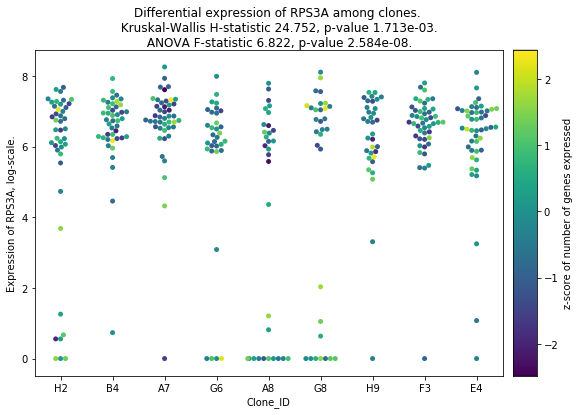

In [141]:
swarm_gene('RPS3A')

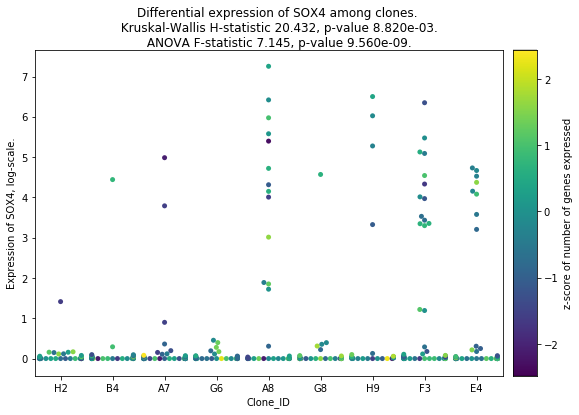

In [142]:
swarm_gene('SOX4')

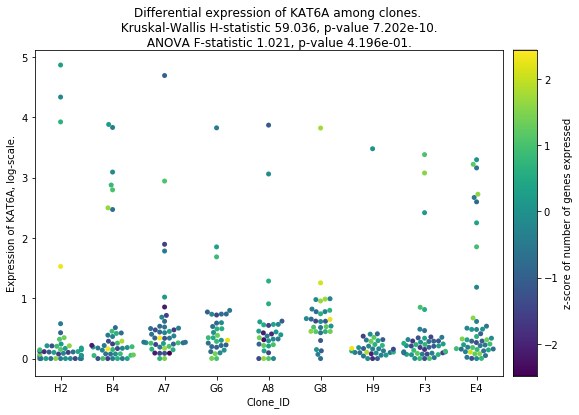

In [143]:
swarm_gene('KAT6A')

It seems like some (like SOX4) of the problematic genes (significant with respect to one statistic, insignificant for another) may be due to high droupouts.  This would yield numerous ties in the ranking which underlies the H-statistic, effectively a low population within clones, and large differences in variability between genes.  It might be a good idea to avoid genes which have very high overall dropout rate.  Genes like KAT6A exhibit similar problems, with high dropout, and also a large number of near-dropouts (low expression level).

Other genes, like RPS3A do not have a high dropout rate, but still have discrepancies in significance.  This seems due to the fact that occasional (within a few clones) dropout does not affect rank statistics (e.g. median) as much as it affects means.

Practically speaking, it might be best to take the intersection of the F-DE and H-DE genes to avoid such problems.  These are the genes stored in the list `genes_FH`.

In [145]:
print(genes_FH)

['MT-ND4', 'SIRPG', 'CCL3', 'MT-ND5', 'HLA-DRA', 'CCR1', 'ANXA2', 'CXCR3', 'LAG3', 'ISG20', 'CLECL1', 'CLIC3', 'SLC31A2', 'ANKRD1', 'CD28', 'CD200R1', 'CCL4L2', 'SIT1', 'MTRNR2L10', 'FAM49A', 'COTL1', 'CD40LG', 'RDH10', 'HLA-DPB1', 'CDKN1A', 'CRIM1', 'SALL4', 'SOCS2', 'CAPG', 'GPR15', 'SH3BGRL3', 'STK17B', 'WIPI1', 'PVRIG', 'LY6E', 'S100A4', 'GZMK', 'FKBP11', 'HLA-DRB1', 'RASGEF1B', 'ITGB1', 'ACTG1', 'CREM', 'FCMR', 'SELL', 'PLSCR1', 'ACTB', 'SET', 'IFITM2', 'PCLAF', 'GZMB', 'SAMD3', 'GZMH', 'NKG7', 'CORO1A', 'TRAT1', 'KIAA0319L', 'PALLD', 'HLA-DMA', 'NDFIP2', 'TC2N', 'JAML', 'BIN1', 'NAMPT', 'ZNF302', 'REG4', 'ENTPD1', 'AXL', 'CTSW', 'KLRC2', 'MX1', 'CADM1', 'HLA-G', 'SERINC5', 'IL32', 'HLA-DRB5', 'ARHGDIB', 'CTSC', 'CMTM6', 'ASB2', 'MAF', 'RGS1', 'RAD54L2', 'NABP1', 'CTLA4', 'FUT8', 'RAB29', 'ADAM19', 'RUNX2', 'IL2RA', 'KLRK1', 'NUCB2', 'PECAM1', 'EMP3', 'HLA-DPA1', 'LMAN1', 'GIMAP7', 'SPOCK1', 'LGALS3BP', 'STEAP1', 'CTSL', 'PCSK5', 'KLRC1', 'MT-ND4L', 'IFI44L', 'ADD2', 'PLEK', 'ID2'

### Exploring clonal gene behaviors.

We capture gene behavior here by three statistics:  the nonzero ratio (100% minus the percentage of dropouts), the mean nonzero (mean of nonzero TPM values), and the variance nonzero (variance of the nonzero TPM values).  We produce a scatterplot of the genes in these three dimensions, with variance represented in color.

In [146]:
def dropmean(df, cutoff, genelist = None, absolute=True):
    if genelist:
        behave_df = df[genelist]
    else:
        behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    varnz_df = behave_df.apply(lambda column: column.replace(co, np.nan).var() )
    dm_df = pd.concat([dropout_df, meannz_df, varnz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero", 2:"Variance nonzero"})
    return dm_df

We create a dataframe with all (7000+) genes, their nonzero ratio, mean nonzero expression, and the variance of their nonzero expression.

In [147]:
dm_df = dropmean(EM, 10, genes)
dm_df.head()

,Nonzero Ratio,Mean nonzero,Variance nonzero
A1BG,0.109510,4.414582,0.409729
AAAS,0.066282,4.884937,0.590245
AAED1,0.374640,4.221548,0.864746
AAGAB,0.227666,4.808627,1.004386
AAK1,0.374640,3.541667,0.350107


We visualize this below, with variance portrayed by color.  Note that rarely-expressed genes have already been filtered out in preprocessing, as well as some often-lowly-expressed genes (bad libraries?). 

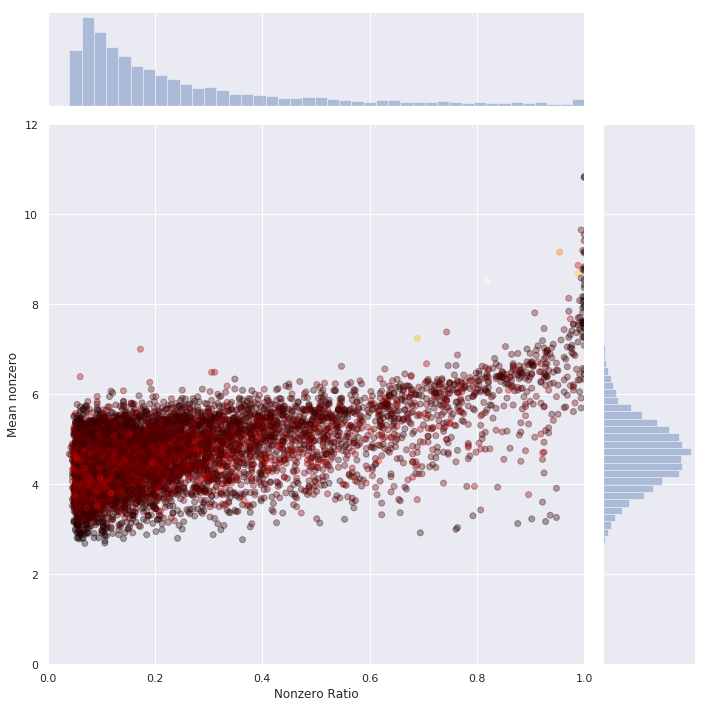

In [149]:
sns.set(style="darkgrid")

cmap = plt.get_cmap("hot")
norm = pcolors.Normalize(vmin=dm_df['Variance nonzero'].min(), vmax=dm_df['Variance nonzero'].max())    
colors = dm_df['Variance nonzero'].apply(lambda cval : cmap(norm(cval)))

fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
                    alpha=.35, xlim=(0,1), ylim=(0,12), height=10,
                    joint_kws={"color":colors} )# Put the legend out of the figure

One way to understand the differential expression of genes is to consider how the statistics -- nonzero ratio, mean nonzero expression, and variance -- differ among the clones (for a fixed genes).  How do they "spread out" from the overall statistic.  First, we compute these statistics at the clonal level.

In [154]:
def dropmean_clones(df, mf, cutoff, genelist = None, absolute=True):
    if genelist:
        behave_df = df[genelist]
    else:
        behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    allmeannz = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    
    behave_df['Clone_ID'] = mf['Clone_ID']
    
    dropout_df = behave_df.groupby('Clone_ID').apply(lambda column: ((column > co).sum()) / len(column) )
    meannz_df = behave_df.groupby('Clone_ID').apply(lambda column: column.replace(co, np.nan).mean())
    varnz_df = behave_df.groupby('Clone_ID').apply(lambda column: column.replace(co, np.nan).var() )
    dropout_df = dropout_df.fillna(0)
    dropout_df = dropout_df.drop('Clone_ID', axis=1) # How did that column get there anyways?
    meannz_df = meannz_df.fillna(allmeannz) # All dropouts -- set mean-nonzero to overall mean.
    varnz_df = varnz_df.fillna(0)
    return dropout_df, meannz_df, varnz_df

In [155]:
d_df, m_df, v_df = dropmean_clones(EM, meta_df, 10, genes_FH)

Next, we produce a visualization of the "spread" for each gene, and for lists of genes.

In [156]:
import matplotlib.lines as mlines

def spread_genes(genelist):
    sns.set(style="darkgrid")
    cmap = plt.get_cmap("hot")
    norm = pcolors.Normalize(vmin=dm_df['Variance nonzero'].min(), vmax=dm_df['Variance nonzero'].max())    
    colors = dm_df['Variance nonzero'].apply(lambda cval : cmap(norm(cval)))
    
    cols = min(len(genelist), 5)
    rows = (len(genelist) // 5)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3,rows*3), sharex = True, sharey = True)
    fig.suptitle('Overall and clonal behavior of {} genes'.format(len(genelist)))
    plotno = 0
    for gene in genelist:
        ax = axes[(plotno // 5), plotno%5]
        plotno += 1
        ax.set_xlim(0,1.05)
        #ax.set_xlabel('Nonzero ratio')
        #ax.set_ylabel('Mean nonzero')
        x_center = dm_df.loc[gene]['Nonzero Ratio']
        y_center = dm_df.loc[gene]['Mean nonzero']
        c_center = colors[gene]
        ax.set_ylim(- np.log(5), np.log(5) )
        foldlist = [np.log(n) for n in range(4,0,-1)] + [-np.log(n) for n in range(2,5)]
        foldlabels = ['1/4-fold', '1/3-fold', '1/2-fold', 'mean', '2-fold', '3-fold', '4-fold']
        ax.set_yticks(foldlist)
        ax.set_yticklabels(foldlabels[::-1])
        ax.plot(x_center, 0, marker='o', markersize=5, color=c_center)
        ax.set_title(gene)
        #ax.text(x_center, +0.2, gene)
        x_list = d_df[gene]
        y_list = m_df[gene] - y_center
        v_list = v_df[gene]
        #display(v_list)
        #c_list = cmap(norm(list(v_list.values)))
        for clone in clones:
            if clone in ['H2', 'B4']:
                marker = '$MEM$'
            elif clone in ['G6', 'A8', 'G8', 'H9', 'F3']:
                marker = '$EFF$'
            elif clone == 'A7':
                marker = '$A7$'
            else:
                marker = '$E4$'
            ax.plot([x_center, x_list[clone]], 
                     [0, y_list[clone]], 
                     color=cmap(norm(v_list[clone])))
            
            ax.plot(x_list[clone], y_list[clone], marker=marker, markersize=14, color=cmap(norm(v_list[clone])))
    
    mems = mlines.Line2D([], [], marker='$MEM$', linestyle='None',
                          markersize=10, label='MEM clones')
    effs = mlines.Line2D([], [], marker='$EFF$', linestyle='None',
                          markersize=10, label='EFF clones')
    a7s = mlines.Line2D([], [], marker='$A7$', linestyle='None',
                          markersize=10, label='A7')
    e4s = mlines.Line2D([], [], marker='$E4$', linestyle='None',
                          markersize=10, label='E4')

    #plt.legend(handles=[mems, effs, a7s, e4s])
    
    plt.show()

In [157]:
def spread_gene(gene, nullhyp = True):
    sns.set(style="darkgrid")
    cmap = plt.get_cmap("hot")
    norm = pcolors.Normalize(vmin=dm_df['Variance nonzero'].min(), vmax=dm_df['Variance nonzero'].max())    
    colors = dm_df['Variance nonzero'].apply(lambda cval : cmap(norm(cval)))
    
    fig, ax = plt.subplots(figsize=(9,9))
    fig.suptitle('Overall and clonal behavior of {}'.format(gene))

    ax.set_xlabel('Nonzero ratio')
    ax.set_ylabel('Mean nonzero')
    x_center = dm_df.loc[gene]['Nonzero Ratio']
    y_center = dm_df.loc[gene]['Mean nonzero']
    c_center = colors[gene]
    ax.set_xlim(0,1.05)
    ax.set_ylim(- np.log(5), np.log(5) )
    foldlist = [np.log(n) for n in range(4,0,-1)] + [-np.log(n) for n in range(2,5)]
    foldlabels = ['1/4-fold', '1/3-fold', '1/2-fold', 'mean', '2-fold', '3-fold', '4-fold']
    ax.set_yticks(foldlist)
    ax.set_yticklabels(foldlabels[::-1])
    ax.plot(x_center, 0, marker='o', markersize=10) #, color=c_center)
    #ax.text(x_center, 0.2, gene)
    ax.set_title(gene)
    x_list = d_df[gene]
    y_list = m_df[gene] - y_center
    v_list = v_df[gene]
    for clone in clones:
        if clone in ['H2', 'B4']:
            marker = '$MEM$'
        elif clone in ['G6', 'A8', 'G8', 'H9', 'F3']:
            marker = '$EFF$'
        elif clone == 'A7':
            marker = '$A7$'
        else:
            marker = '$E4$'
        ax.plot([x_center, x_list[clone]], [0, y_list[clone]], color=cmap(norm(v_list[clone])))
                #marker=marker, markersize=20, 
                #color=cmap(norm(v_list[clone])))
        ax.plot(x_list[clone], y_list[clone], marker=marker, markersize=20, color=cmap(norm(v_list[clone])))
    
    mems = mlines.Line2D([], [], marker='$MEM$', linestyle='None',
                          markersize=10, label='MEM clones')
    effs = mlines.Line2D([], [], marker='$EFF$', linestyle='None',
                          markersize=10, label='EFF clones')
    a7s = mlines.Line2D([], [], marker='$A7$', linestyle='None',
                          markersize=10, label='A7')
    e4s = mlines.Line2D([], [], marker='$E4$', linestyle='None',
                          markersize=10, label='E4')

    plt.legend(handles=[mems, effs, a7s, e4s])
    
    plt.show()

Let's take a look at the differential expression of ANXA1.

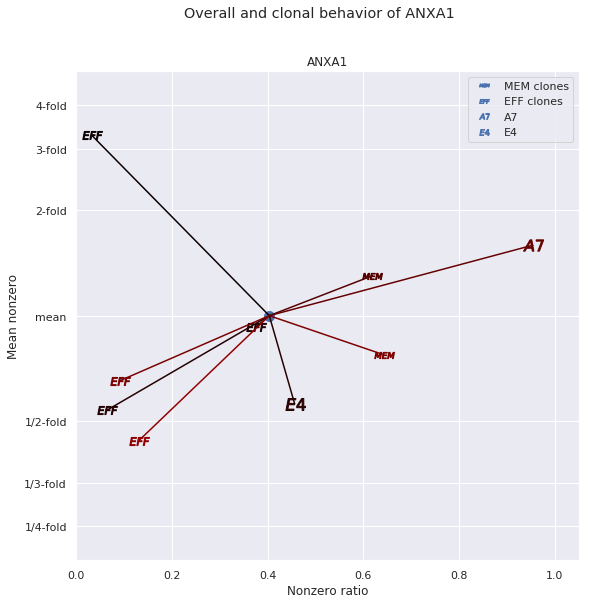

In [160]:
spread_gene('ANXA1')

We see a lot of "horizontal" spread, as A7 clones almost always express ANXA1, while four of the EFF-clones almost never (<10%) express ANXA1 above the cutoff.  Moreover, there is a "vertical" spread too... while this probably shouldn't be interpreted for the rarely expressed clones (mean nonzero of a very small population!) the two MEM-clones are vertically displaced.  There's more than a 2-fold change in *nonzero* expression level, if one compares the E4 and A7 clones.

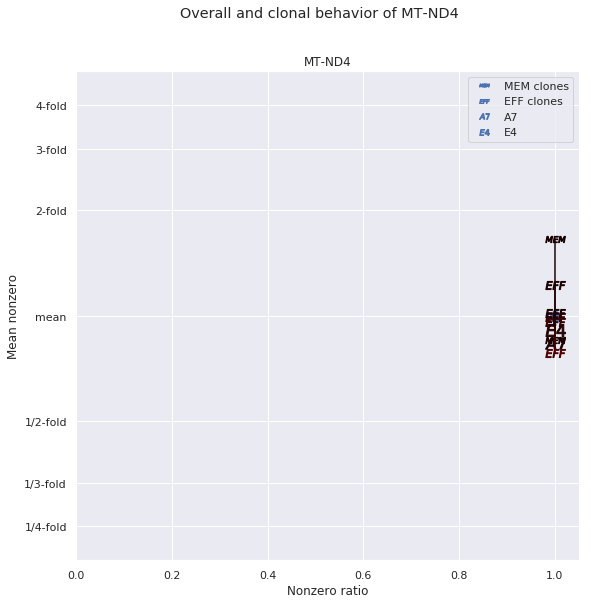

In [161]:
spread_gene('MT-ND4')

The gene MT-ND4 is always expressed, among all clones.  But there is a vertical spread, with about a 2-fold difference between the highest-expressing clones and the lowest.

It may be useful to "zoom out" and see such snapshots for dozens of genes at once, to see the variety of behaviors.  That's what we do below.

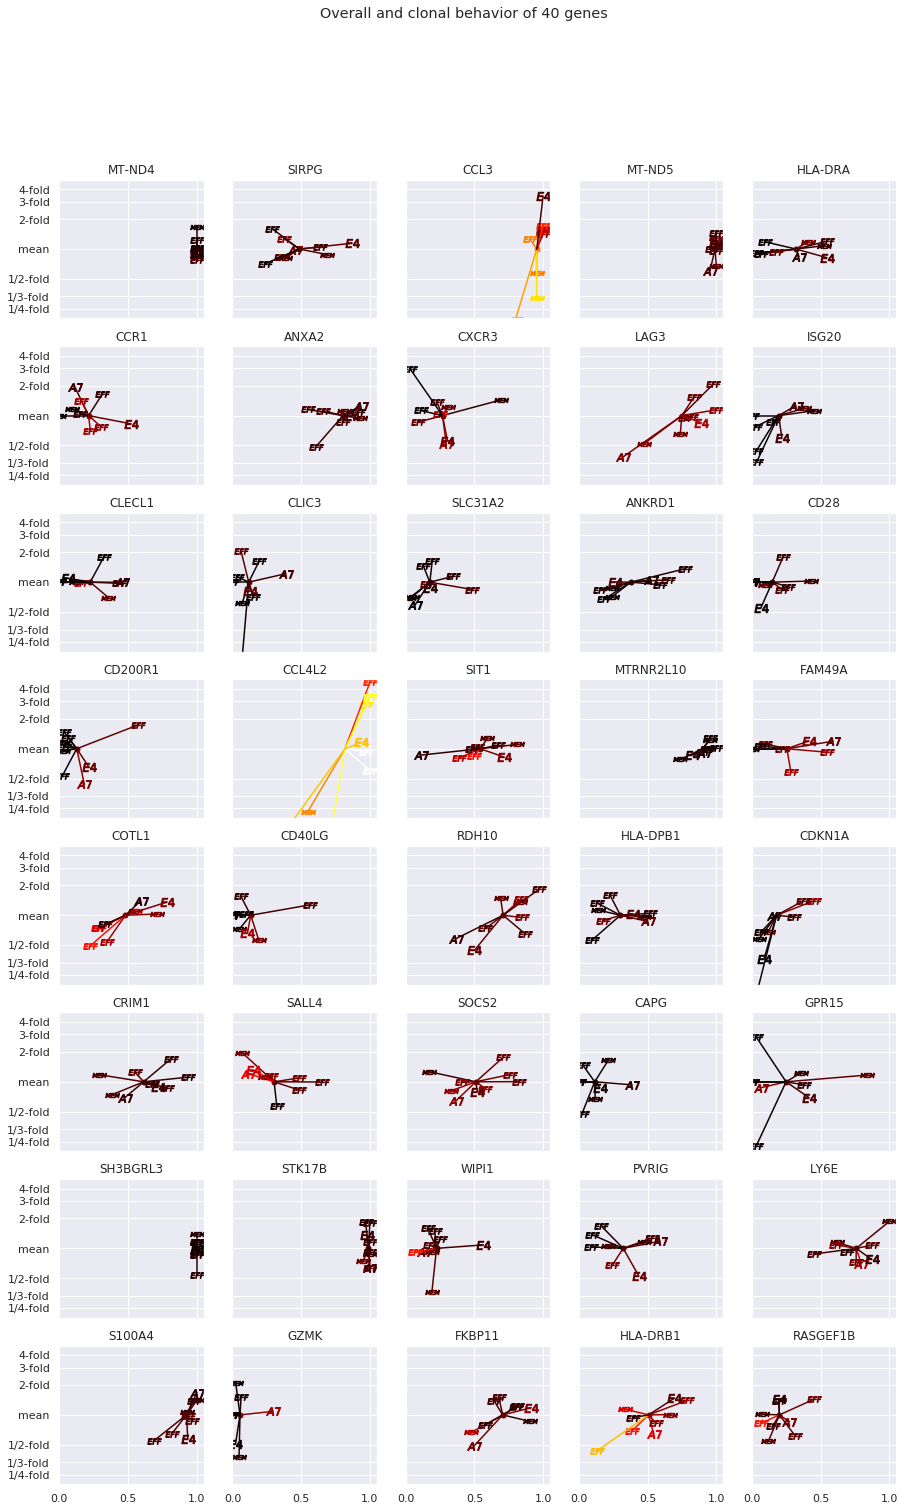

In [162]:
spread_genes(genes_FH[:40])

Can one find a correlation between these "shapes" of differential expression behavior and ATAC peaks?

It's a bit hard to see whether these "spreads" are statistically significant, although the H and F statistics indicate significance at the $p < 10^{-6}$ level.  To visualize the significance, we overlay the results of a permutation test.  Namely, we randomly shuffle the clone-labels of cells (1000 times), and shade the plots with green dots where the randomly-produced spreads land.  This is computationally more intensive.

In [163]:
def perm_spread(gene, cutoff=10, absolute=True, num_iter = 1000):
    gene_exp = EM[gene]
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    gene_exp.clip(lower=co, inplace=True)
    gene_meannz = gene_exp.replace(co, np.nan).mean()
    
    # Set up figure.
    fig, ax = plt.subplots(figsize=(6,5))
    fig.suptitle('Overall and clonal behavior of {}'.format(gene))
    ax.set_xlabel('Nonzero ratio')
    ax.set_ylabel('Mean nonzero')
    ax.set_xlim(0,1.05)
    ax.set_ylim(- np.log(5), np.log(5) )
    foldlist = [np.log(n) for n in range(4,0,-1)] + [-np.log(n) for n in range(2,5)]
    foldlabels = ['1/4-fold', '1/3-fold', '1/2-fold', 'mean', '2-fold', '3-fold', '4-fold']
    ax.set_yticks(foldlist)
    ax.set_yticklabels(foldlabels[::-1])
    
    # Plot center point
    x_center = (gene_exp > co).sum() / len(gene_exp)
    y_center = gene_meannz
    ax.plot(x_center, 0, marker='o', markersize=10) #, color=c_center)
    
    xlist = np.zeros((num_iter, len(clones)))
    ylist = np.zeros((num_iter, len(clones)))
    
    # Data frame of permuted cells.
    rand_df = pd.DataFrame(0, index=EM.index, columns=np.arange(num_iter))
    rand_df = rand_df.apply(lambda column : np.random.permutation(gene_exp))
    rand_df['Clone_ID'] = meta_df['Clone_ID']
    rand_df[gene] = gene_exp
    
    # Compute dropout ratio and mean nonzero.
    dropout_df = rand_df.groupby('Clone_ID').apply(lambda column: ((column > co).sum()) / len(column) )
    meannz_df = rand_df.groupby('Clone_ID').apply(lambda column: column.replace(co, np.nan).mean())
    dropout_df = dropout_df.fillna(0)
    dropout_df = dropout_df.drop('Clone_ID', axis=1) # How did that column get there anyways?
    meannz_df = meannz_df.fillna(gene_meannz) # All dropouts -- set mean-nonzero to overall mean.
    meannz_df = meannz_df - gene_meannz # Shift by overall mean

    # Show null hypothesis expectations 
    sns.kdeplot(dropout_df.drop(gene, axis=1).values.flatten(), meannz_df.drop(gene, axis=1).values.flatten(), 
                ax=ax, cbar=True, shade=True, shade_lowest = False, cmap="Greens")
    
    
    x_list = dropout_df[gene]
    y_list = meannz_df[gene]
    for clone in clones:
        if clone in ['H2', 'B4']:
            marker = '$MEM$'
        elif clone in ['G6', 'A8', 'G8', 'H9', 'F3']:
            marker = '$EFF$'
        elif clone == 'A7':
            marker = '$A7$'
        else:
            marker = '$E4$'
        ax.plot([x_center, x_list[clone]], [0, y_list[clone]], color='k')
        ax.plot(x_list[clone], y_list[clone], marker=marker, markersize=20, color='k')
    
    mems = mlines.Line2D([], [], marker='$MEM$', linestyle='None',
                          markersize=10, label='MEM clones')
    effs = mlines.Line2D([], [], marker='$EFF$', linestyle='None',
                          markersize=10, label='EFF clones')
    a7s = mlines.Line2D([], [], marker='$A7$', linestyle='None',
                          markersize=10, label='A7')
    e4s = mlines.Line2D([], [], marker='$E4$', linestyle='None',
                          markersize=10, label='E4')

    plt.legend(handles=[mems, effs, a7s, e4s])
    
    plt.show()

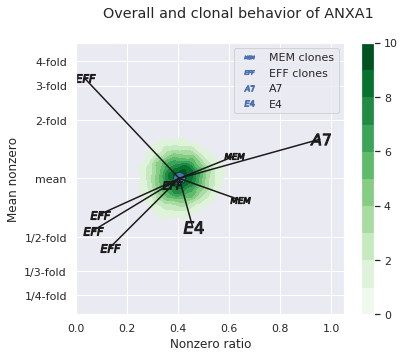

In [164]:
perm_spread('ANXA1')

The null hypothesis predicts the clones to all lie within the green blob (based on 1000 random permutations of clone-labels).  This gives us an indication of how significant this spread is.  Here are a few more examples.

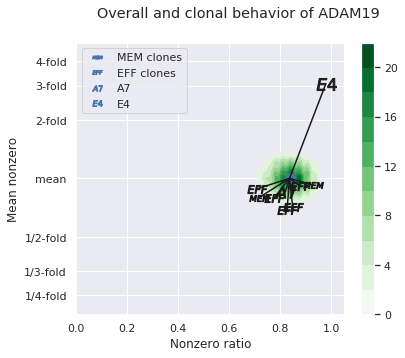

In [165]:
perm_spread('ADAM19')

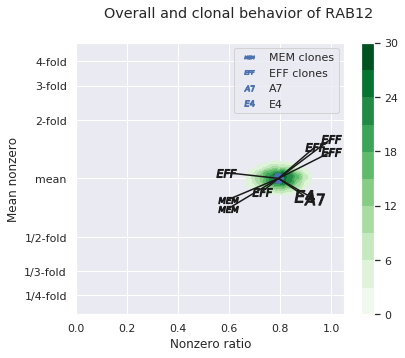

In [166]:
perm_spread('RAB12')

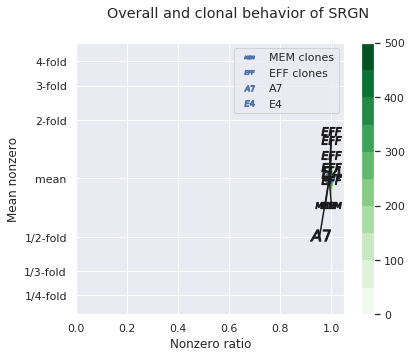

In [167]:
perm_spread('SRGN')

For genes like SRGN which are almost always expresed, the "green blob" of the null hypothesis is exceedingly small.  The roughly 4-fold difference in expression levels between the highest-expressed (EFF) clones and the A7 clones is significant.

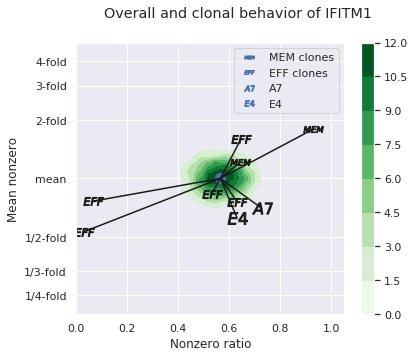

In [168]:
perm_spread('IFITM1')

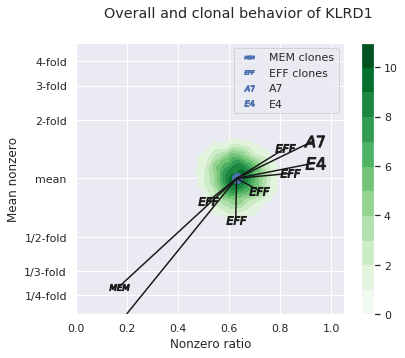

In [169]:
perm_spread('KLRD1')

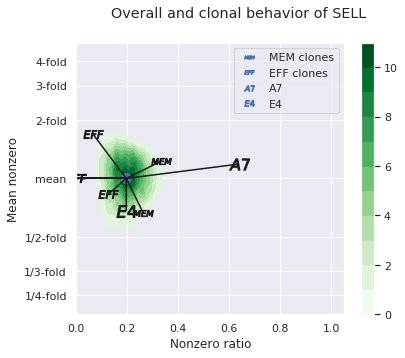

In [170]:
perm_spread('SELL')

## Exporting the differentially expressed genes

We have identified genes as differentially expressed based on ANOVA F statistic and Kruskal-Wallis H statistic.  The *way* in which genes are differentially expressed is visualized in the "behavior" plots of the previous section.  Some genes vary from clone to clone in their nonzero ratio -- perhaps their burst frequency varies, so dropout frequency changes in the snapshots of single-cell data.  For other genes, expression is almost always detected, but different clones have different expression levels.  

Here we create a dataframe for export, containing this sort of information.  We declare a gene to be differentially expressed (a DEG) if both F and H statistic satisfy $p < 10^{-3}$.  This is not a very strict cutoff, especially with >7000 genes.  But we sort our dataframe by p-value to place the most statistically significant DEGs at the top.

In [202]:
genes_H3 = H_frame[ H_frame.pvalue < 1e-3].index
genes_F3 = F_frame[ F_frame.pvalue < 1e-3].index
print('{} genes significant at p<0.001 for the H-statistic.'.format(len(genes_H3)))
print('{} genes significant at p<0.001 for the F-statistic.'.format(len(genes_F3)))

1225 genes significant at p<0.001 for the H-statistic.
923 genes significant at p<0.001 for the F-statistic.


In [206]:
genes_DE = list(set(genes_F3).intersection(genes_H3)) # Intersection of H3 and F3 DEGs.
print('{} genes significant at p<0.001 for both H and F statistic.'.format(len(genes_DE)))

787 genes significant at p<0.001 for both H and F statistic.


In [224]:
DE_frame = FH_frame.loc[genes_DE]
DE_frame['chi2'] = onoff_genes['chi2']
DE_frame['chi2_logpvalue'] = np.clip(-np.log10(onoff_genes['p_value']),0,None)
DE_frame['Nonzero Ratio'] = dm_df['Nonzero Ratio']
DE_frame['Is innate'] = [(gene in genes_innate) for gene in DE_frame.index]
DE_frame.drop(['F', 'H', 'chi2'], inplace=True, axis=1)
DE_frame.sort_values('F_logpvalue', ascending = False, inplace = True)
DE_frame.round(3)

,F_logpvalue,H_logpvalue,chi2_logpvalue,Nonzero Ratio,Is innate
LRRC28,58.035,28.414,16.010,0.311,False
REG4,51.397,43.942,28.071,0.141,False
JAML,50.126,35.947,13.516,0.516,False
KLRC2,45.426,29.546,10.252,0.602,True
KLRC3,42.509,30.006,9.739,0.504,True
CCL4L2,42.323,30.836,0.645,0.818,True
IL32,41.392,28.593,0.000,1.000,True
KIN,39.408,31.467,0.000,1.000,False
CXCR6,38.443,29.509,8.374,0.620,True
KLRD1,37.940,25.896,1.342,0.628,True


In [234]:
DE_frame.round(3).to_csv('DEGs_P1902.csv')

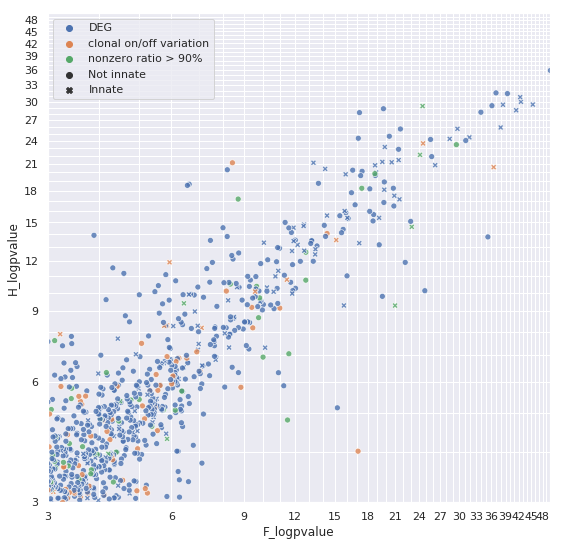

In [231]:
fix,ax = plt.subplots(figsize=(9,9))
oftenlist = ['nonzero ratio > 90%' if (DE_frame.loc[gene,'Nonzero Ratio'] >= 0.9 and DE_frame.loc[gene,'F_logpvalue'] > 6) 
             else 'clonal on/off variation' if (DE_frame.loc[gene,'Nonzero Ratio'] < 0.9 and DE_frame.loc[gene,'chi2_logpvalue'] > 6)
             else 'DEG' 
             for gene in genes_DE ]
#chilist = ['onoff' if x < 1e-3 else 'not onoff' for x in DE_frame['chi2_logpvalue']]
inn_list = ['Innate' if DE_frame.loc[gene, 'Is innate']
            else 'Not innate'
           for gene in DE_frame.index]
sns.scatterplot(x='F_logpvalue', y='H_logpvalue', hue = oftenlist, style = inn_list, data=DE_frame, alpha=0.8, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xbound(6,50)
ax.set_ybound(6,50)

ax.set_xticks(range(3,50))
ax.set_yticks(range(3,50))
ll = list(range(3,50))
for j in range(len(ll)):
    if (ll[j]%3 != 0) and (ll[j] > 3):
        ll[j] = ''
ax.set_xticklabels(ll)
ax.set_yticklabels(ll)
ax.minorticks_off()

plt.show()